Solar Panels 

In [25]:
# ===========================
# import necessary Libraries
# ===========================

import sys, os, glob, gc
import joblib
import pandas as pd
import types
import numpy as np
from datetime import datetime
from helper import fill_missing_values, drop_missing_values, plot_outliers




In [26]:
# ====== patch for compatibility with old pandas version ======
def patch_pandas_index_compat():
    import pandas as _pd
    import types as _types
    numeric = _types.ModuleType("pandas.core.indexes.numeric")
    class Int64Index(_pd.Index):
        def __new__(cls, data=None, dtype=None, copy=False, name=None):
            return _pd.Index(data, dtype="int64", copy=copy, name=name)
    numeric.Int64Index = Int64Index
    numeric.RangeIndex = _pd.RangeIndex
    sys.modules['pandas.core.indexes.numeric'] = numeric

    dat = _types.ModuleType("pandas.core.indexes.datetimes")
    dat.DatetimeIndex = _pd.DatetimeIndex
    sys.modules['pandas.core.indexes.datetimes'] = dat

    tdel = _types.ModuleType("pandas.core.indexes.timedeltas")
    tdel.TimedeltaIndex = _pd.TimedeltaIndex
    sys.modules['pandas.core.indexes.timedeltas'] = tdel

patch_pandas_index_compat()


In [27]:
# ===============================================================
# ☀️ Merge all .pkl files and split the data by SEASONS automatically
# 📦 Combine all .pkl files, standardize columns, split by season, and save as separate .h5 files
# ===============================================================

import os, pandas as pd, joblib, glob, gc, re

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
store_path = os.path.join(DATA_DIR, "all_data.h5")

# 🧹 Safely close if already open
try:
    pd.io.pytables.close_store(store_path)
except Exception:
    pass

# 🧼 Remove old file if it exists
if os.path.exists(store_path):
    os.remove(store_path)

# 📂 Find all .pkl files
files = sorted(glob.glob(os.path.join(DATA_DIR, "df*.pkl")))
print(f"📁 Found {len(files)} .pkl files in {DATA_DIR}\n")

if len(files) == 0:
    raise SystemExit("❌ No .pkl files found!")

# 🧩 Load first file for column names
template_df = joblib.load(files[0])

# 🧽 Clean column names
def clean_hdf_colname(col):
    col = col.strip().lower()
    col = re.sub(r'[\/\(\)\%\-\s\n\r]+', '_', col)
    col = re.sub(r'_+', '_', col)
    col = col.strip('_')
    return col

template_df.columns = [clean_hdf_colname(c) for c in template_df.columns]
template_columns = list(template_df.columns)

print(f"📋 Using {os.path.basename(files[0])} as column template ({len(template_columns)} columns).")

# 🏗️ Create HDF5 store
store = pd.HDFStore(store_path, mode='w', complevel=9, complib='blosc')

# 🧠 Merge all files
for i, file in enumerate(files, start=1):
    name = os.path.basename(file)
    print(f"\n📂 Loading file {i}/{len(files)} → {name}")
    
    df = joblib.load(file)
    df.columns = template_columns  # Force same column names

    print(f"✅ {name}: {len(df)} rows × {len(df.columns)} columns")
    store.append('merged', df, format='table')  # ✅ fixed line (no bool)
    
    del df
    gc.collect()

store.close()

print(f"\n✅ All files merged successfully → {store_path}")

# ✅ Verify
with pd.HDFStore(store_path, 'r') as store:
    df = store['/merged']
    print(f"🔑 Key '/merged' found → Final shape: {df.shape}")
    print(f"🧾 Columns ({len(df.columns)}): {list(df.columns)}")


📁 Found 5 .pkl files in /Users/shthaz/Desktop/Solar_Panels2/Data

📋 Using df1.pkl as column template (23 columns).

📂 Loading file 1/5 → df1.pkl
✅ df1.pkl: 528097 rows × 23 columns

📂 Loading file 2/5 → df2.pkl
✅ df2.pkl: 528097 rows × 23 columns

📂 Loading file 3/5 → df3.pkl
✅ df3.pkl: 528097 rows × 23 columns

📂 Loading file 4/5 → df4.pkl
✅ df4.pkl: 528097 rows × 23 columns

📂 Loading file 5/5 → df5.pkl
✅ df5.pkl: 528097 rows × 23 columns

✅ All files merged successfully → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data.h5
🔑 Key '/merged' found → Final shape: (2640485, 23)
🧾 Columns (23): ['time', 'total_solar_irradiance_on_inclined_plane_poa1_w_m2', 'total_solar_irradiance_on_inclined_plane_poa1_wh_m2', 'total_solar_irradiance_on_inclined_plane_poa2_w_m2', 'total_solar_irradiance_on_inclined_plane_poa2_wh_m2', 'total_solar_irradiance_on_horizontal_plane_ghi_w_m2', 'total_solar_irradiance_on_horizontal_plane_ghi_wh_m2', 'ambient_temp._degree_centigrade', 'module_surface_temperature

In [28]:
# ===============================================================
# 🌤️ Split merged data by season and save each to a separate file
# ===============================================================

print("\n📆 Splitting data into seasons...")

# 🧾 Load merged data
df = pd.read_hdf(store_path, key='merged')

# Ensure the 'time' column exists
if 'time' not in df.columns:
    raise KeyError("❌ Column 'time' not found in dataset!")

# Convert time column to datetime (just in case)
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Define season function
def get_season(month):
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "fall"

# Add season column
df['season'] = df['time'].dt.month.apply(get_season)

# Save each season into a separate .h5 file
for season in ['winter', 'spring', 'summer', 'fall']:
    season_df = df[df['season'] == season].drop(columns=['season'])

    # ✅ Ensure 'time' column exists as a proper column (not index)
    if 'time' not in season_df.columns:
        season_df = season_df.reset_index().rename(columns={'index': 'time'})
    else:
        # Make sure time column is in correct datetime format
        season_df['time'] = pd.to_datetime(season_df['time'], errors='coerce')

    # Reorder columns so that 'time' is always the first column
    cols = ['time'] + [c for c in season_df.columns if c != 'time']
    season_df = season_df[cols]

    # Save cleaned seasonal file
    out_path = os.path.join(DATA_DIR, f"all_data_{season}.h5")
    season_df.to_hdf(out_path, key='df', mode='w', complevel=9, complib='blosc')

    print(f"💾 Saved {season.upper()} → {out_path} | Shape: {season_df.shape}")

# 🧮 Print summary
summary = df['season'].value_counts().to_dict()
print("\n==============================")
print("📊 Seasonal Split Summary")
print("==============================")
for s, count in summary.items():
    print(f"🌤️ {s.capitalize():<8} → {count:,} rows")
print("------------------------------")
print(f"🧮 Total rows (all seasons) → {len(df):,}")
print("==============================")

del df
gc.collect()



📆 Splitting data into seasons...
💾 Saved WINTER → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_winter.h5 | Shape: (661250, 23)
💾 Saved SPRING → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_spring.h5 | Shape: (654535, 23)
💾 Saved SUMMER → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_summer.h5 | Shape: (669500, 23)
💾 Saved FALL → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_fall.h5 | Shape: (655200, 23)

📊 Seasonal Split Summary
🌤️ Summer   → 669,500 rows
🌤️ Winter   → 661,250 rows
🌤️ Fall     → 655,200 rows
🌤️ Spring   → 654,535 rows
------------------------------
🧮 Total rows (all seasons) → 2,640,485


93

In [29]:
# ================================================================
# 🧹 Clean each seasonal dataset safely (no data leakage)
# ================================================================
import pandas as pd
import numpy as np
import re, os, gc
from helper import drop_missing_values, fill_missing_values

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")

season_files = {
    "winter": os.path.join(DATA_DIR, "all_data_winter.h5"),
    "spring": os.path.join(DATA_DIR, "all_data_spring.h5"),
    "summer": os.path.join(DATA_DIR, "all_data_summer.h5"),
    "fall":   os.path.join(DATA_DIR, "all_data_fall.h5"),
}

# Store cleaning summaries for all seasons
cleaning_reports = {}

for season, path in season_files.items():
    if not os.path.exists(path):
        print(f"⚠️ File not found for {season}: {path}")
        continue

    print("\n" + "="*70)
    print(f"🧹 Cleaning {season.upper()} dataset ...")
    print("="*70)

    # Load dataset
    df = pd.read_hdf(path, key="df")
    original_shape = df.shape

    # Initialize counters
    removed_rows = 0
    night_rows = 0
    duplicate_groups = 0
    imputed_cells = 0
    removed_cols = 0

    # ================================================================
    # 1️⃣ Remove rows with missing target (Active Power)
    # ================================================================
    target_col = df.columns[-1]
    before_drop = len(df)
    df = drop_missing_values(df, columns=[target_col])
    removed_rows = before_drop - len(df)
    print(f"🗑️ Removed {removed_rows:,} rows with missing target → {df.shape}")

    # ================================================================
    # 2️⃣ Detect night/day and set nighttime negative target to 0
    # ================================================================
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
        df['minutes_since_midnight'] = df['time'].dt.hour * 60 + df['time'].dt.minute
        df['Day_Night'] = np.where(
            (df['minutes_since_midnight'] >= 525) & (df['minutes_since_midnight'] <= 1080),
            'day', 'night'
        )
        night_rows = (df['Day_Night'] == 'night').sum()
        df.loc[(df['Day_Night'] == 'night') & (df[target_col] < 0), target_col] = 0
        print(f"🌙 Set nighttime negative target values to 0 → {night_rows:,} rows checked")
    else:
        print("⚠️ 'time' column not found — skipping night/day step.")

    # ================================================================
    # 3️⃣ Handle duplicate timestamps (average same-minute readings only)
    # ================================================================
    if 'time' in df.columns:
        df = df.sort_values('time')

        # Round to the nearest minute to detect duplicates within the same minute
        df['minute_group'] = df['time'].dt.floor('min')

        unique_minutes = df['minute_group'].nunique()
        total_rows = len(df)
        duplicates_count = total_rows - unique_minutes
        pct_duplicates = (duplicates_count / total_rows * 100)

        print(f"\n🕒 Minute-level duplicate analysis:")
        print(f"   • Total rows: {total_rows:,}")
        print(f"   • Unique minute timestamps: {unique_minutes:,}")
        print(f"   • Duplicate rows (same minute): {duplicates_count:,}")
        print(f"   • % Duplicated by minute: {pct_duplicates:.2f}%")

        # Show sample of duplicated minute groups
        duplicated_minutes = df['minute_group'].value_counts()
        repeated_minutes = duplicated_minutes[duplicated_minutes > 1].head(10)
        if not repeated_minutes.empty:
            print("\n📊 Top 10 most repeated minute timestamps:")
            print(repeated_minutes)
        else:
            print("✅ No repeated minute timestamps found.")

        # Merge duplicates by taking the mean of numeric columns
        if duplicates_count > 0:
            print("⚙️ Averaging duplicate minute entries...")
            df = df.groupby('minute_group', as_index=False).mean(numeric_only=True)
            df = df.rename(columns={'minute_group': 'time'})
            print(f"📉 Total rows after minute-level merge: {len(df):,}")
        else:
            print("✅ No duplicate rows within the same minute found.")
    else:
        print("⚠️ 'time' column not found — skipping duplicate check.")

    # ================================================================
    # 4️⃣ Fill missing values using linear interpolation
    # ================================================================
    missing_before = df.isna().sum().sum()
    df = fill_missing_values(df, use_interpolation=True)
    missing_after = df.isna().sum().sum()
    imputed_cells = missing_before - missing_after
    print(f"🧮 Filled missing values → {imputed_cells:,} cells interpolated.")

    # ================================================================
    # 5️⃣ Remove duplicated-unit columns (W/m² vs Wh/m²)
    # ================================================================
    before_cols = df.shape[1]
    pattern_wh = re.compile(r'(Wh.?/?m2|Wh.?/?m²|Wh_per_m2|Wh_m2)', re.IGNORECASE)
    wh_cols = [c for c in df.columns if pattern_wh.search(c)]

    # Manual columns to remove
    manual_remove = [
        'Total_Solar_Irradiance_on_Inclined_Plane_POA2_W_m2',
        'Total_Solar_Irradiance_on_Inclined_Plane_POA2_Wh_m2'
    ]
    wh_cols.extend(manual_remove)
    wh_cols = list(set(wh_cols))

    if wh_cols:
        print("\n🗑️ Removing duplicate-unit columns:")
        for c in wh_cols:
            print(f"   - {c}")
        df = df.drop(columns=wh_cols, errors='ignore')
    else:
        print("✅ No duplicate-unit columns found.")

    removed_cols = before_cols - df.shape[1]

    # ================================================================
    # 6️⃣ Drop helper time columns
    # ================================================================
    df = df.drop(columns=['minutes_since_midnight', 'Day_Night'], errors='ignore')

    # ================================================================
    # 💾 Save cleaned dataset
    # ================================================================
    clean_path = os.path.join(DATA_DIR, f"all_data_{season}_clean.h5")
    df.to_hdf(clean_path, key="df", mode="w", complevel=9, complib="blosc")

    # ================================================================
    # 📋 Summary for this file
    # ================================================================
    report = {
        "Original Shape": original_shape,
        "Final Shape": df.shape,
        "Rows Removed (missing target)": removed_rows,
        "Nighttime rows processed": night_rows,
        "Duplicate rows merged (same minute)": duplicates_count,
        "Cells interpolated": imputed_cells,
        "Columns removed": removed_cols,
    }

    cleaning_reports[season] = report

    print("\n📋 Cleaning Summary for", season.upper())
    for k, v in report.items():
        print(f"   • {k}: {v}")
    print("✅ Cleaning complete.\n")

    gc.collect()

print("\n🎯 All seasonal datasets cleaned successfully!")



🧹 Cleaning WINTER dataset ...
🗑️ Removed 4,630 rows with missing target → (656620, 23)
🌙 Set nighttime negative target values to 0 → 403,840 rows checked

🕒 Minute-level duplicate analysis:
   • Total rows: 656,620
   • Unique minute timestamps: 129,891
   • Duplicate rows (same minute): 526,729
   • % Duplicated by minute: 80.22%

📊 Top 10 most repeated minute timestamps:
minute_group
2020-02-04 13:03:00    10
2020-02-04 17:55:00    10
2020-02-04 18:15:00    10
2020-02-04 18:14:00    10
2020-02-04 18:13:00    10
2020-02-04 18:12:00    10
2020-02-04 18:11:00    10
2020-02-04 18:10:00    10
2020-02-04 18:09:00    10
2020-02-04 18:08:00    10
Name: count, dtype: int64
⚙️ Averaging duplicate minute entries...
📉 Total rows after minute-level merge: 129,891
🔁 Filled missing values using linear interpolation.
🧮 Filled missing values → 11,829 cells interpolated.

🗑️ Removing duplicate-unit columns:
   - total_solar_irradiance_on_horizontal_plane_ghi_wh_m2
   - total_solar_irradiance_on_incli

In [30]:
# ============================================================
# 📊 Detect and Summarize Outliers for Each Seasonal Dataset
# ============================================================

from helper import plot_outliers
import pandas as pd, os

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")

#files
season_files = {
    "winter": os.path.join(DATA_DIR, "all_data_winter.h5"),
    "spring": os.path.join(DATA_DIR, "all_data_spring.h5"),
    "summer": os.path.join(DATA_DIR, "all_data_summer.h5"),
    "fall":   os.path.join(DATA_DIR, "all_data_fall.h5"),
}

outlier_reports = {}

for season, path in season_files.items():
    if not os.path.exists(path):
        print(f"⚠️ File not found for {season}: {path}")
        continue

    print(f"\n==============================")
    print(f"📂 Checking outliers for {season.upper()} dataset...")
    print("==============================")

    # read 
    df_season = pd.read_hdf(path, key='df')

    # call helper
    outlier_report = plot_outliers(df_season)

    # save
    outlier_reports[season] = outlier_report

print("\n✅ Outlier detection complete for all seasonal datasets!")



📂 Checking outliers for WINTER dataset...

📊 Outlier Summary Report (IQR method):
                                              Column  Outliers  % of Total  Lower Bound  Upper Bound
                             soiling_loss_index_geff    100884      15.321       -7.315        6.713
                              soiling_loss_index_isc     58281       8.851       -0.982        1.448
                                      wind_speed_m_s     10488       1.593       -2.313        6.988
 total_solar_irradiance_on_horizontal_plane_ghi_w_m2      7894       1.199     -479.816      799.693
                                      geff_test_w_m2      5504       0.836     -488.660      814.441
                                 geff_reference_w_m2      4119       0.626     -501.366      835.663
                     ambient_temp._degree_centigrade      1634       0.248       -4.155       25.906
                              temperature_test_deg_c      1073       0.163      -22.523       51.756
        

In [31]:
# ================================================================
# ✂️ Outlier Clipping (IQR method per column - Full Report)
# ================================================================
import pandas as pd, numpy as np, os

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
seasons = ["winter", "spring", "summer", "fall"]

for season in seasons:
    path = os.path.join(DATA_DIR, f"all_data_{season}_clean.h5")
    df = pd.read_hdf(path, 'df')
    print("="*70)
    print(f"📦 Loading cleaned dataset for {season.upper()}...")
    print(f"✅ Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

    num_cols = df.select_dtypes(include=[np.number]).columns
    print(f"🧮 Found {len(num_cols)} numeric columns for clipping.\n")

    clipping_summary = []
    total_clipped = 0

    for col in num_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        before = df[col].copy()

        # Count outliers before clipping
        outliers_before = np.sum((before < lower) | (before > upper))

        # Apply clipping
        df[col] = np.clip(df[col], lower, upper)

        # Count outliers after clipping (should be 0 ideally)
        after = df[col]
        outliers_after = np.sum((after < lower) | (after > upper))

        total_clipped += outliers_before

        clipping_summary.append({
            "Column": col,
            "Outliers_Before": int(outliers_before),
            "Outliers_After": int(outliers_after),
            "Lower_Bound": round(lower, 3),
            "Upper_Bound": round(upper, 3)
        })

    out_path = os.path.join(DATA_DIR, f"all_data_{season}_clipped.h5")
    df.to_hdf(out_path, key='df', mode='w', complevel=9, complib='blosc')

    print(f"✅ Saved clipped dataset → {out_path}")
    print(f"📊 Total clipped (before correction): {total_clipped:,}\n")

    summary_df = pd.DataFrame(clipping_summary)
    print("📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):")
    display(summary_df.sort_values("Outliers_Before", ascending=False).head(15))

print("\n🎯 IQR-based clipping completed successfully for all seasonal datasets!")


📦 Loading cleaned dataset for WINTER...
✅ Loaded: 129,891 rows × 20 columns
🧮 Found 19 numeric columns for clipping.

✅ Saved clipped dataset → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_winter_clipped.h5
📊 Total clipped (before correction): 49,673

📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):


,Column,Outliers_Before,Outliers_After,Lower_Bound,Upper_Bound
11,soiling_loss_index_geff,24862,0,-3.981,3.763
10,soiling_loss_index_isc,20129,0,-0.666,1.078
6,wind_speed_m_s,1433,0,-2.262,6.957
2,total_solar_irradiance_on_horizontal_plane_ghi...,1204,0,-475.418,792.363
3,ambient_temp._degree_centigrade,461,0,-3.906,25.581
16,geff_test_w_m2,456,0,-502.590,837.668
17,geff_reference_w_m2,399,0,-508.549,847.636
15,temperature_reference_cell_deg_c,183,0,-22.012,50.570
14,temperature_test_deg_c,179,0,-21.995,50.987
4,module_surface_temperature1_degree_centigrade,123,0,-21.867,50.035


📦 Loading cleaned dataset for SPRING...
✅ Loaded: 130,418 rows × 20 columns
🧮 Found 19 numeric columns for clipping.

✅ Saved clipped dataset → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_spring_clipped.h5
📊 Total clipped (before correction): 68,578

📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):


,Column,Outliers_Before,Outliers_After,Lower_Bound,Upper_Bound
16,geff_test_w_m2,20998,0,-317.851,529.757
17,geff_reference_w_m2,19548,0,-340.228,567.081
11,soiling_loss_index_geff,12779,0,-0.253,3.632
10,soiling_loss_index_isc,8451,0,-0.444,1.882
9,relative_humidity,3596,0,-15.782,72.193
6,wind_speed_m_s,3118,0,-2.245,7.475
8,daily_rain_mm,68,0,0.000,0.000
13,isc_ref_amp,10,0,-3.782,6.303
12,isc_test_amp,10,0,-3.776,6.294
15,temperature_reference_cell_deg_c,0,0,-26.040,84.062


📦 Loading cleaned dataset for SUMMER...
✅ Loaded: 132,453 rows × 20 columns
🧮 Found 19 numeric columns for clipping.

✅ Saved clipped dataset → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_summer_clipped.h5
📊 Total clipped (before correction): 35,383

📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):


,Column,Outliers_Before,Outliers_After,Lower_Bound,Upper_Bound
10,soiling_loss_index_isc,13676,0,-0.475,1.664
11,soiling_loss_index_geff,13676,0,-0.402,1.605
9,relative_humidity,5146,0,-4.761,38.565
7,wind_direction_degree,2134,0,28.864,447.156
6,wind_speed_m_s,704,0,-2.127,7.092
13,isc_ref_amp,11,0,-4.228,7.047
17,geff_reference_w_m2,11,0,-1357.692,2262.878
16,geff_test_w_m2,9,0,-1352.277,2253.829
12,isc_test_amp,9,0,-4.214,7.023
8,daily_rain_mm,4,0,0.000,0.000


📦 Loading cleaned dataset for FALL...
✅ Loaded: 130,976 rows × 20 columns
🧮 Found 19 numeric columns for clipping.

✅ Saved clipped dataset → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_fall_clipped.h5
📊 Total clipped (before correction): 47,946

📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):


,Column,Outliers_Before,Outliers_After,Lower_Bound,Upper_Bound
10,soiling_loss_index_isc,20155,0,-0.035,1.527
11,soiling_loss_index_geff,18717,0,-0.019,1.526
9,relative_humidity,6523,0,-28.352,82.277
6,wind_speed_m_s,2425,0,-1.705,5.255
8,daily_rain_mm,101,0,0.000,0.000
16,geff_test_w_m2,8,0,-977.729,1629.570
12,isc_test_amp,7,0,-3.014,5.023
17,geff_reference_w_m2,5,0,-980.451,1634.129
13,isc_ref_amp,5,0,-3.021,5.036
15,temperature_reference_cell_deg_c,0,0,-24.993,85.069



🎯 IQR-based clipping completed successfully for all seasonal datasets!


In [32]:
# ================================================================
# ✂️ Split Each Seasonal Dataset into Train & Test (No Data Leakage)
# ================================================================
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# Define data folder
DATA_DIR = "/Users/shthaz/Desktop/Solar_Panels2/Data"

# Define seasonal files
seasons = ["winter", "spring", "summer", "fall"]

for season in seasons:
    clean_path = os.path.join(DATA_DIR, f"all_data_{season}_clipped.h5")

    if not os.path.exists(clean_path):
        print(f"⚠️ File not found for {season.upper()}: {clean_path}")
        continue

    print(f"\n📂 Processing {season.upper()} dataset...")

    # Load cleaned dataset
    df_clean = pd.read_hdf(clean_path, 'df')
    print(f"✅ Loaded: {df_clean.shape[0]:,} rows, {df_clean.shape[1]:,} columns")

    # Split features & target
    target_col = df_clean.columns[-1]
    X = df_clean.iloc[:, :-1]
    y = df_clean.iloc[:, -1]

    # Split into train/test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Combine features + target
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df  = pd.concat([X_test, y_test], axis=1)

    # Define save paths
    train_path = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    test_path  = os.path.join(DATA_DIR, f"all_data_{season}_test_clean.h5")

    # Save to disk
    train_df.to_hdf(train_path, key='df', mode='w', complevel=9, complib='blosc')
    test_df.to_hdf(test_path, key='df', mode='w', complevel=9, complib='blosc')

    # Print summary
    print(f"✅ Split completed for {season.upper()}")
    print(f"📘 Train set → {train_df.shape[0]:,} rows | {train_df.shape[1]:,} columns")
    print(f"📗 Test  set → {test_df.shape[0]:,} rows | {test_df.shape[1]:,} columns")
    print(f"💾 Saved:\n   - {train_path}\n   - {test_path}")

print("\n🎯 All seasonal datasets split successfully!")



📂 Processing WINTER dataset...
✅ Loaded: 129,891 rows, 20 columns
✅ Split completed for WINTER
📘 Train set → 103,912 rows | 20 columns
📗 Test  set → 25,979 rows | 20 columns
💾 Saved:
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_winter_train_clean.h5
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_winter_test_clean.h5

📂 Processing SPRING dataset...
✅ Loaded: 130,418 rows, 20 columns
✅ Split completed for SPRING
📘 Train set → 104,334 rows | 20 columns
📗 Test  set → 26,084 rows | 20 columns
💾 Saved:
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_spring_train_clean.h5
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_spring_test_clean.h5

📂 Processing SUMMER dataset...
✅ Loaded: 132,453 rows, 20 columns
✅ Split completed for SUMMER
📘 Train set → 105,962 rows | 20 columns
📗 Test  set → 26,491 rows | 20 columns
💾 Saved:
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_summer_train_clean.h5
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_summer_tes

In [33]:
# ================================================================
# 📊 Feature Selection with Target-Correlation Filtering + IG + PCC + Spearman
# ================================================================

from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import joblib
import os

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
seasons = ["winter", "spring", "summer", "fall"]

# -----------------------------
# 🔁 Loop through all seasons
# -----------------------------
for season in seasons:
    print("\n" + "="*70)
    print(f"🍃 Feature Selection for {season.upper()} dataset")
    print("="*70)

    # Load train/test for this season
    train_path = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    test_path  = os.path.join(DATA_DIR, f"all_data_{season}_test_clean.h5")

    if not os.path.exists(train_path):
        print(f"⚠️ Train file not found for {season.upper()} — skipping.")
        continue

    train_df = pd.read_hdf(train_path, "df")
    print(f"📦 Loaded train data: {train_df.shape[0]:,} rows, {train_df.shape[1]} cols")

    # Split X and y
    X_train = train_df.iloc[:, :-1]
    y_train = train_df.iloc[:, -1]

    print(f"✅ Target column: '{y_train.name}'")

    # =====================================================
    # 1️⃣ Remove non-numeric and constant columns
    # =====================================================
    print("\n🧹 Checking for non-numeric and constant features...")

    non_numeric = X_train.columns.difference(X_train.select_dtypes(include=[np.number]).columns).tolist()
    X_train = X_train.select_dtypes(include=[np.number])

    constant_cols = X_train.columns[X_train.nunique() <= 1].tolist()
    X_train = X_train.loc[:, X_train.nunique() > 1]

    if non_numeric or constant_cols:
        print(f"🗑️ Removed {len(non_numeric)} non-numeric and {len(constant_cols)} constant columns:")
        if non_numeric:
            print("   Non-numeric:", ", ".join(non_numeric))
        if constant_cols:
            print("   Constant:", ", ".join(constant_cols))
    else:
        print("✅ No non-numeric or constant columns found.")

    print(f"📊 Remaining features after cleaning: {X_train.shape[1]}")

    # =====================================================
    # 2️⃣ Remove features with correlation ≥ 0.95
    # =====================================================
    print("\n📉 Checking features highly correlated with target (≥ 0.95)...")
    corr_vals = X_train.apply(lambda col: col.corr(y_train, method="pearson"))
    corr_table = pd.DataFrame({
        "Feature": corr_vals.index,
        "Corr_with_Target": corr_vals.values
    }).sort_values(by="Corr_with_Target", ascending=False)

    high_corr = corr_table.loc[corr_table["Corr_with_Target"].abs() >= 0.95, "Feature"].tolist()

    if high_corr:
        print(f"🗑️ Removing {len(high_corr)} features with |corr| ≥ 0.95:")
        for f in high_corr:
            val = corr_table.loc[corr_table["Feature"] == f, "Corr_with_Target"].values[0]
            print(f"   • {f} → corr={val:.4f}")
        X_train = X_train.drop(columns=high_corr, errors="ignore")
    else:
        print("✅ No high-correlation features removed.")

    corr_path = os.path.join(DATA_DIR, f"feature_target_corr_{season}.csv")
    corr_table.to_csv(corr_path, index=False)
    print(f"💾 Saved correlation table → {corr_path}")

    print(f"📊 Remaining features after filtering: {X_train.shape[1]}")

    # =====================================================
    # 3️⃣ Information Gain (Mutual Information)
    # =====================================================
    print("\n📈 Calculating Information Gain (train only)...")
    mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
    ig_df = pd.DataFrame({"Feature": X_train.columns, "IG_Score": mi_scores})
    ig_df["IG_%"] = (ig_df["IG_Score"] / ig_df["IG_Score"].max()) * 100
    ig_df = ig_df.sort_values(by="IG_Score", ascending=False).reset_index(drop=True)

    # ✅ Select all features where IG_% ≥ 10%
    ig_top = ig_df[ig_df["IG_%"] >= 10]

    print(f"🏅 IG: Selected {len(ig_top)} features (IG_% ≥ 10%)")
    print(ig_top[["Feature", "IG_%"]].to_string(index=False, formatters={"IG_%": "{:.2f}%".format}))

    # Save full IG scores
    ig_csv = os.path.join(DATA_DIR, f"ig_scores_{season}.csv")
    ig_df.to_csv(ig_csv, index=False)

    # =====================================================
    # 4️⃣ Pearson Correlation (PCC)
    # =====================================================
    print("\n📊 Calculating Pearson Correlation (train only)...")
    pcc_results = []
    for f in X_train.columns:
        try:
            corr, pval = pearsonr(X_train[f].fillna(0), y_train.fillna(0))
            pcc_results.append((f, corr, abs(corr)))
        except Exception:
            continue

    pcc_df = pd.DataFrame(pcc_results, columns=["Feature", "PCC", "absPCC"])
    pcc_df["PCC_%"] = (pcc_df["absPCC"] / pcc_df["absPCC"].max()) * 100
    pcc_df = pcc_df.sort_values(by="absPCC", ascending=False).reset_index(drop=True)

    # ✅ Select all features where PCC_% ≥ 10%
    pcc_top = pcc_df[pcc_df["PCC_%"] >= 10]

    print(f"🏅 PCC: Selected {len(pcc_top)} features (PCC_% ≥ 10%)")
    print(pcc_top[["Feature", "PCC_%"]].to_string(index=False, formatters={"PCC_%": "{:.2f}%".format}))

    # Save full PCC scores
    pcc_csv = os.path.join(DATA_DIR, f"pcc_scores_{season}.csv")
    pcc_df.to_csv(pcc_csv, index=False)

    # =====================================================
    # 5️⃣ Spearman correlation between IG & PCC
    # =====================================================
    print("\n🔗 Comparing IG & PCC correlations via Spearman...")
    merged = pd.merge(
        ig_top[["Feature", "IG_Score"]],
        pcc_top[["Feature", "absPCC"]],
        on="Feature",
        how="inner"
    )

    if merged.empty:
        print("⚠️ No overlap between IG and PCC sets.")
        spearman_corr = 0
    else:
        spearman_corr, pval = spearmanr(merged["IG_Score"], merged["absPCC"])
        print(f"📊 Spearman correlation = {spearman_corr:.4f}")
        if abs(spearman_corr) >= 0.8:
            print("✅ Strong agreement — either IG or PCC works fine.")
        elif abs(spearman_corr) >= 0.5:
            print("⚖️ Moderate agreement — test both sets.")
        else:
            print("🚨 Low agreement — IG and PCC capture different behaviors.")

    # =====================================================
    # 6️⃣ Save feature sets
    # =====================================================
    selected_features = {
        "ig": ig_top["Feature"].tolist(),
        "pcc": pcc_top["Feature"].tolist(),
        "common": list(set(ig_top["Feature"]) & set(pcc_top["Feature"]))
    }

    out_path = os.path.join(DATA_DIR, f"selected_features_{season}_ig_pcc.joblib")
    joblib.dump(selected_features, out_path)
    print(f"💾 Saved feature sets → {out_path}")
    print(f"✅ Done for {season.upper()} — IG={len(ig_top)}, PCC={len(pcc_top)}, Common={len(selected_features['common'])}")



🍃 Feature Selection for WINTER dataset
📦 Loaded train data: 103,912 rows, 20 cols
✅ Target column: 'control_ppc_active_power_1m'

🧹 Checking for non-numeric and constant features...
🗑️ Removed 1 non-numeric and 1 constant columns:
   Non-numeric: time
   Constant: daily_rain_mm
📊 Remaining features after cleaning: 17

📉 Checking features highly correlated with target (≥ 0.95)...
🗑️ Removing 5 features with |corr| ≥ 0.95:
   • total_solar_irradiance_on_inclined_plane_poa1_w_m2 → corr=0.9930
   • total_solar_irradiance_on_inclined_plane_poa2_w_m2 → corr=0.9923
   • isc_ref_amp → corr=0.9883
   • isc_test_amp → corr=0.9877
   • total_solar_irradiance_on_horizontal_plane_ghi_w_m2 → corr=0.9619
💾 Saved correlation table → /Users/shthaz/Desktop/Solar_Panels2/Data/feature_target_corr_winter.csv
📊 Remaining features after filtering: 12

📈 Calculating Information Gain (train only)...
🏅 IG: Selected 11 features (IG_% ≥ 10%)
                                      Feature    IG_%
                 

📦 Loading training and testing data...
✅ Train: (103912, 20), Test: (25979, 20)
🌙 Removed 55,867 nighttime rows (irradiance < 1)

🚀 Training IG model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

🔧 Best Hyperparameters Found:
   • subsample: 0.5
   • reg_lambda: 1.5
   • reg_alpha: 1.0
   • n_estimators: 200
   • min_child_weight: 5
   • max_depth: 4
   • learning_rate: 0.02
   • colsample_bytree: 0.7

📊 IG Results (Overall):
   R² (Train): 0.9568 | R² (Test-Overall): 0.9663
   RMSE (Train): 21,894.34 | RMSE (Test-Overall): 20,014.92

☀️ IG Results (Daylight-only TEST):
   R² (Test-Day): 0.9567 | RMSE (Test-Day): 21,955.35
   Status (based on Daylight): ✅ Good Fit (ΔRMSE=0.28%)
💾 Saved IG model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_ig_winter.joblib


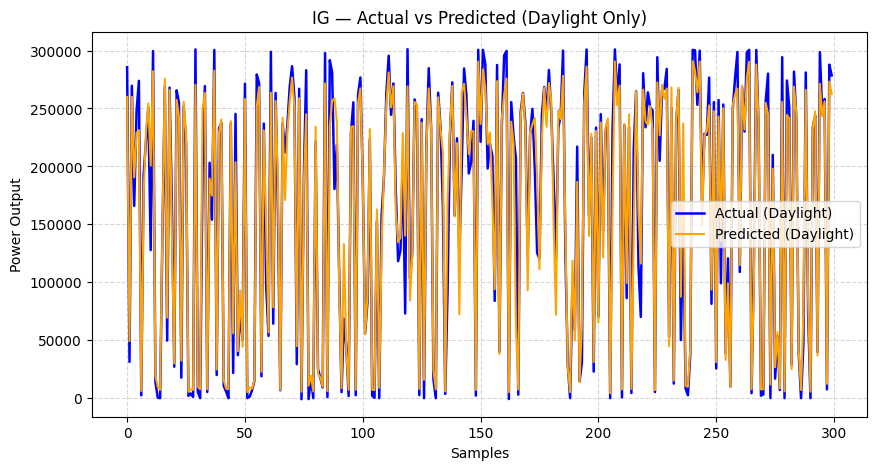

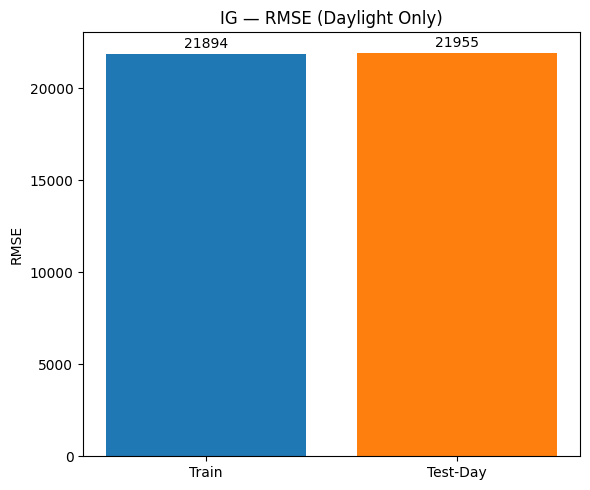

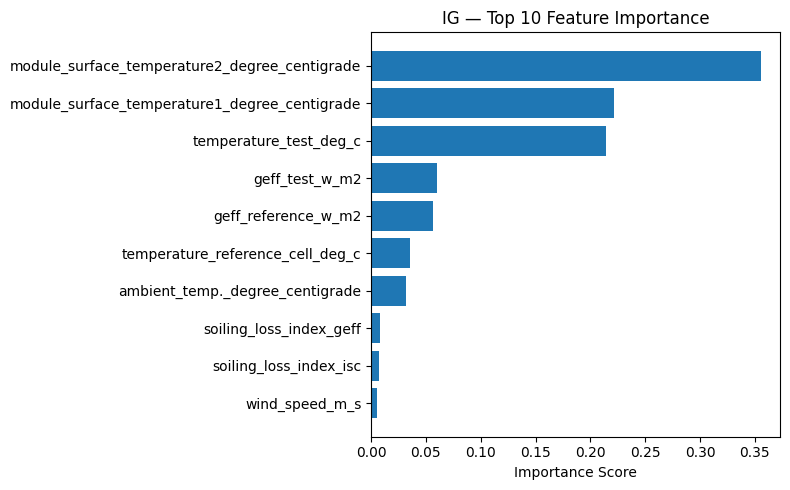


🚀 Training PCC model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

🔧 Best Hyperparameters Found:
   • subsample: 0.5
   • reg_lambda: 1.5
   • reg_alpha: 1.0
   • n_estimators: 200
   • min_child_weight: 5
   • max_depth: 4
   • learning_rate: 0.02
   • colsample_bytree: 0.7

📊 PCC Results (Overall):
   R² (Train): 0.9522 | R² (Test-Overall): 0.9625
   RMSE (Train): 23,042.24 | RMSE (Test-Overall): 21,133.91

☀️ PCC Results (Daylight-only TEST):
   R² (Test-Day): 0.9520 | RMSE (Test-Day): 23,115.96
   Status (based on Daylight): ✅ Good Fit (ΔRMSE=0.32%)
💾 Saved PCC model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_pcc_winter.joblib


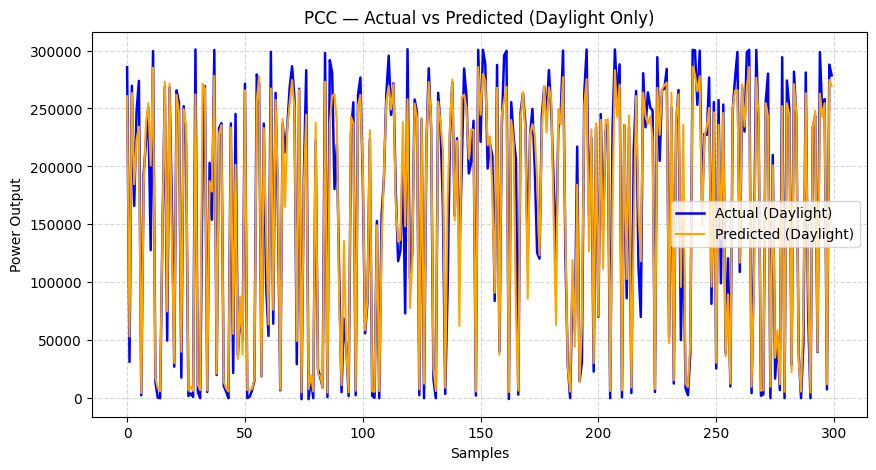

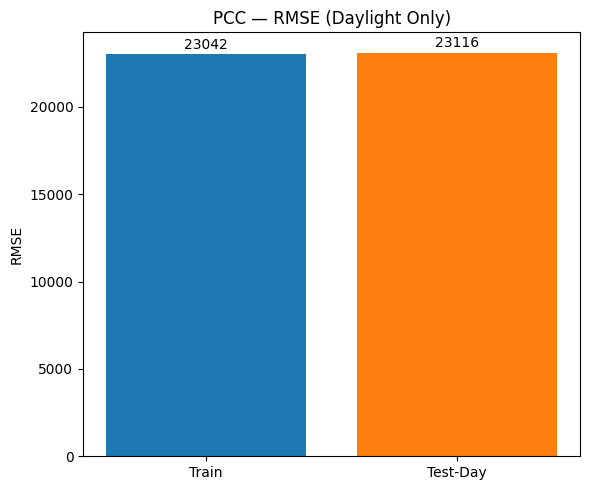

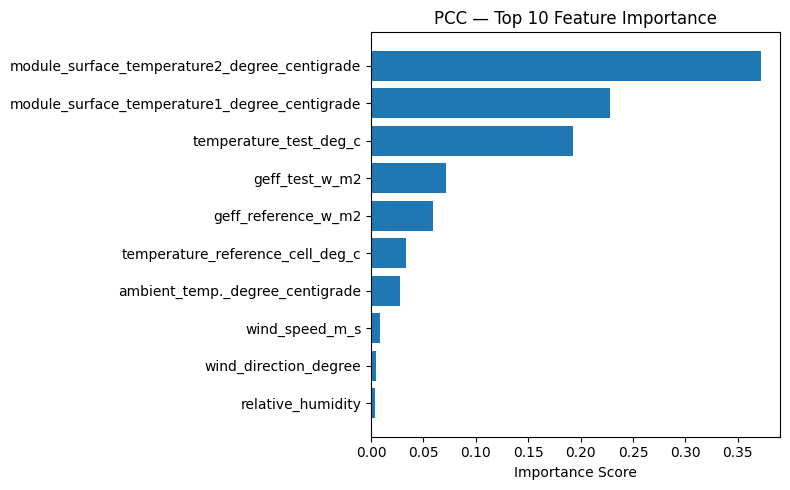


🏁 WINTER MODEL COMPARISON
IG → R²(Test-Day): 0.9567 | RMSE(Test-Day): 21955.4 | Status: ✅ Good Fit
PCC → R²(Test-Day): 0.9520 | RMSE(Test-Day): 23116.0 | Status: ✅ Good Fit

✅ IG performed better for WINTER (Daylight-based).
🏅 Best Hyperparameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'reg_alpha': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.7}
💾 Best model saved as → xgb_winter_best.joblib


In [43]:
# ============================================================
# ❄️ XGBoost Training & Visualization for WINTER (Anti-Overfit - Daylight Visualization)
# ============================================================

import pandas as pd, numpy as np, joblib, os, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
train_path = os.path.join(DATA_DIR, "all_data_winter_train_clean.h5")
test_path  = os.path.join(DATA_DIR, "all_data_winter_test_clean.h5")
features_path = os.path.join(DATA_DIR, "selected_features_winter_ig_pcc.joblib")

# -----------------------------
# 📊 Load data
# -----------------------------
print("📦 Loading training and testing data...")
train_df = pd.read_hdf(train_path, 'df')
test_df  = pd.read_hdf(test_path, 'df')
features = joblib.load(features_path)
print(f"✅ Train: {train_df.shape}, Test: {test_df.shape}")

target_col = train_df.columns[-1]
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

# -----------------------------
# 🚫 Remove nighttime samples (low irradiance ≈ 0)
# -----------------------------
irr_cols = [c for c in X_train.columns if any(k in c.lower() for k in ["ghi", "irradiance", "poa", "w_m2"])]
if irr_cols:
    mask_day = X_train[irr_cols].max(axis=1) > 1
    removed_rows = (~mask_day).sum()
    X_train = X_train[mask_day]
    y_train = y_train[mask_day]
    print(f"🌙 Removed {removed_rows:,} nighttime rows (irradiance < 1)")
else:
    print("⚠️ No irradiance-related columns found — skipped filtering.")

# -----------------------------
# ⚙️ Parameter Grid (Balanced)
# -----------------------------
param_grid = {
    "n_estimators": [80, 120, 150, 200],
    "learning_rate": [0.005, 0.01, 0.02],
    "max_depth": [3, 4],
    "subsample": [0.5, 0.6, 0.7],
    "colsample_bytree": [0.5, 0.6, 0.7],
    "reg_alpha": [0.5, 0.8, 1.0],
    "reg_lambda": [1.5, 2.0, 2.5, 3.0],
    "min_child_weight": [5, 7, 9]
}

# -----------------------------
# 🧠 Training Function
# -----------------------------
def train_and_evaluate(X_train, y_train, X_test, y_test, feature_set_name, feature_list):
    print(f"\n🚀 Training {feature_set_name} model...")

    model = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=25,
        cv=5,
        verbose=1,
        n_jobs=-1,
        scoring='r2',
        random_state=42
    )

    search.fit(X_train[feature_list], y_train)
    best_model = search.best_estimator_
    best_params = search.best_params_

    print("\n🔧 Best Hyperparameters Found:")
    for k, v in best_params.items():
        print(f"   • {k}: {v}")

    # 📊 Predictions
    y_pred_train = best_model.predict(X_train[feature_list])
    y_pred_test  = best_model.predict(X_test[feature_list])

    # --- Overall metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test_overall  = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test_overall  = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # --- Daylight-only (fair comparison)
    irr_cols_test = [c for c in X_test.columns if any(k in c.lower() for k in ["ghi","irradiance","poa","w_m2"])]
    if irr_cols_test:
        mask_day_test = X_test[irr_cols_test].max(axis=1) > 1
        y_test_day  = y_test[mask_day_test]
        y_pred_day  = y_pred_test[mask_day_test]

        if len(y_test_day) > 0:
            r2_test_day   = r2_score(y_test_day, y_pred_day)
            rmse_test_day = np.sqrt(mean_squared_error(y_test_day, y_pred_day))
        else:
            r2_test_day, rmse_test_day = np.nan, np.nan
    else:
        mask_day_test = None
        r2_test_day, rmse_test_day = np.nan, np.nan

    # --- Delta RMSE & Status
    if not np.isnan(rmse_test_day):
        delta_rmse = ((rmse_test_day - rmse_train) / rmse_train) * 100
    else:
        delta_rmse = ((rmse_test_overall - rmse_train) / rmse_train) * 100

    if delta_rmse > 30:
        status = "🚨 Overfitting!"
    elif delta_rmse < -10:
        status = "⚠️ Underfitting!"
    else:
        status = "✅ Good Fit"

    # -----------------------------
    # 🖨️ Report
    # -----------------------------
    print(f"\n📊 {feature_set_name} Results (Overall):")
    print(f"   R² (Train): {r2_train:.4f} | R² (Test-Overall): {r2_test_overall:.4f}")
    print(f"   RMSE (Train): {rmse_train:,.2f} | RMSE (Test-Overall): {rmse_test_overall:,.2f}")

    if not np.isnan(rmse_test_day):
        print(f"\n☀️ {feature_set_name} Results (Daylight-only TEST):")
        print(f"   R² (Test-Day): {r2_test_day:.4f} | RMSE (Test-Day): {rmse_test_day:,.2f}")
        print(f"   Status (based on Daylight): {status} (ΔRMSE={delta_rmse:.2f}%)")
    else:
        print(f"\n⚠️ Daylight mask not available on TEST — Status based on Overall: {status} (ΔRMSE={delta_rmse:.2f}%)")

    # 💾 Save model
    model_path = os.path.join(DATA_DIR, f"xgb_{feature_set_name.lower()}_winter.joblib")
    joblib.dump(best_model, model_path)
    print(f"💾 Saved {feature_set_name} model → {model_path}")

    # 🎨 Actual vs Predicted (Daylight only)
    plt.figure(figsize=(10,5))
    plt.plot(y_test_day.values[:300], label="Actual (Daylight)", color="blue", linewidth=1.8)
    plt.plot(y_pred_day[:300], label="Predicted (Daylight)", color="orange", linewidth=1.5)
    plt.title(f"{feature_set_name} — Actual vs Predicted (Daylight Only)")
    plt.xlabel("Samples")
    plt.ylabel("Power Output")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # 📊 RMSE (Train vs Test-Day)
    plt.figure(figsize=(6,5))
    bars = plt.bar(["Train","Test-Day"], [rmse_train, rmse_test_day], color=["#1f77b4","#ff7f0e"])
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x()+b.get_width()/2, h + 300, f"{h:.0f}", ha='center', fontsize=10)
    plt.title(f"{feature_set_name} — RMSE (Daylight Only)")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()

    # 🔍 Feature Importance
    plt.figure(figsize=(8,5))
    importance = best_model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    plt.barh(np.array(feature_list)[sorted_idx][:10][::-1],
             importance[sorted_idx][:10][::-1], color="#1f77b4")
    plt.title(f"{feature_set_name} — Top 10 Feature Importance")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

    return {
        "name": feature_set_name,
        "model": best_model,
        "best_params": best_params,
        "r2_train": r2_train,
        "r2_test_overall": r2_test_overall,
        "rmse_train": rmse_train,
        "rmse_test_overall": rmse_test_overall,
        "r2_test_day": r2_test_day,
        "rmse_test_day": rmse_test_day,
        "status": status
    }

# -----------------------------
# 🧪 Train both IG & PCC
# -----------------------------
ig_result = train_and_evaluate(X_train, y_train, X_test, y_test, "IG", features["ig"])
pcc_result = train_and_evaluate(X_train, y_train, X_test, y_test, "PCC", features["pcc"])

# -----------------------------
# 🏁 Compare and Save Best Model
# -----------------------------
print("\n===============================")
print("🏁 WINTER MODEL COMPARISON")
print("===============================")
print(f"IG → R²(Test-Day): {ig_result['r2_test_day']:.4f} | RMSE(Test-Day): {ig_result['rmse_test_day']:.1f} | Status: {ig_result['status']}")
print(f"PCC → R²(Test-Day): {pcc_result['r2_test_day']:.4f} | RMSE(Test-Day): {pcc_result['rmse_test_day']:.1f} | Status: {pcc_result['status']}")

if ig_result['r2_test_day'] > pcc_result['r2_test_day']:
    print("\n✅ IG performed better for WINTER (Daylight-based).")
    print(f"🏅 Best Hyperparameters: {ig_result['best_params']}")
    joblib.dump(ig_result["model"], os.path.join(DATA_DIR, "xgb_winter_best.joblib"))
else:
    print("\n✅ PCC performed better for WINTER (Daylight-based).")
    print(f"🏅 Best Hyperparameters: {pcc_result['best_params']}")
    joblib.dump(pcc_result["model"], os.path.join(DATA_DIR, "xgb_winter_best.joblib"))

print("💾 Best model saved as → xgb_winter_best.joblib")


📦 Loading training and testing data...
✅ Train: (104334, 20), Test: (26084, 20)
🌙 Removed 46,811 nighttime rows (irradiance < 1)

🚀 Training IG model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

🔧 Best Hyperparameters Found:
   • subsample: 0.5
   • reg_lambda: 1.5
   • reg_alpha: 1.0
   • n_estimators: 200
   • min_child_weight: 5
   • max_depth: 4
   • learning_rate: 0.02
   • colsample_bytree: 0.7

📊 IG Results (Overall):
   R² (Train): 0.9713 | R² (Test-Overall): 0.9878
   RMSE (Train): 19,134.13 | RMSE (Test-Overall): 14,708.33

☀️ IG Results (Daylight-only TEST):
   R² (Test-Day): 0.9716 | RMSE (Test-Day): 19,166.32
   Status (based on Daylight): ✅ Good Fit (ΔRMSE=0.17%)
💾 Saved IG model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_ig_spring.joblib


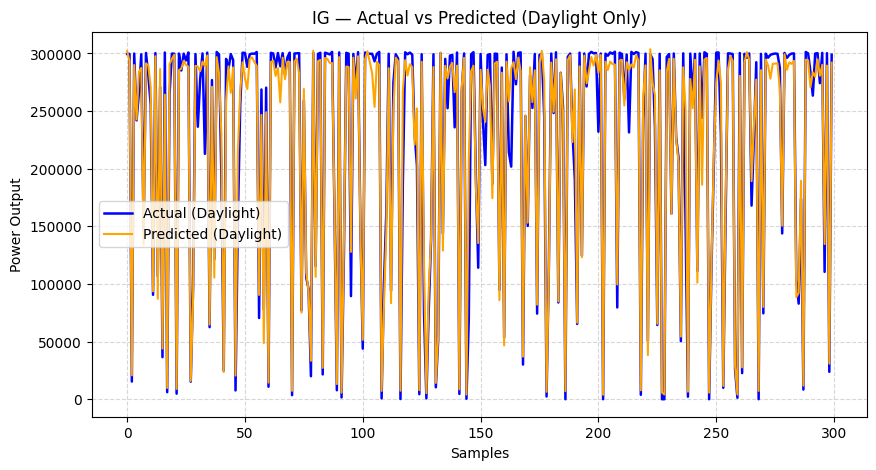

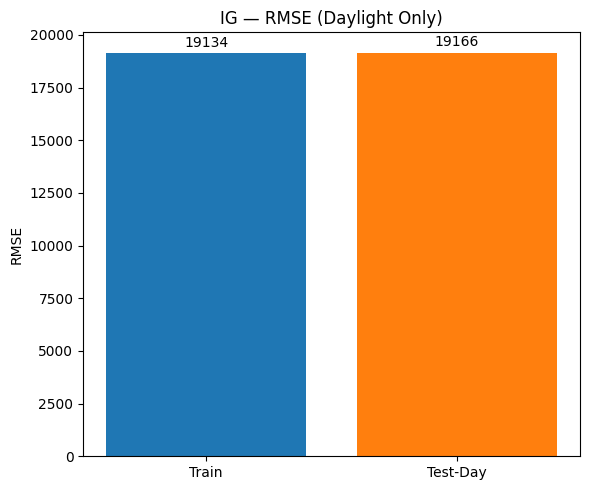

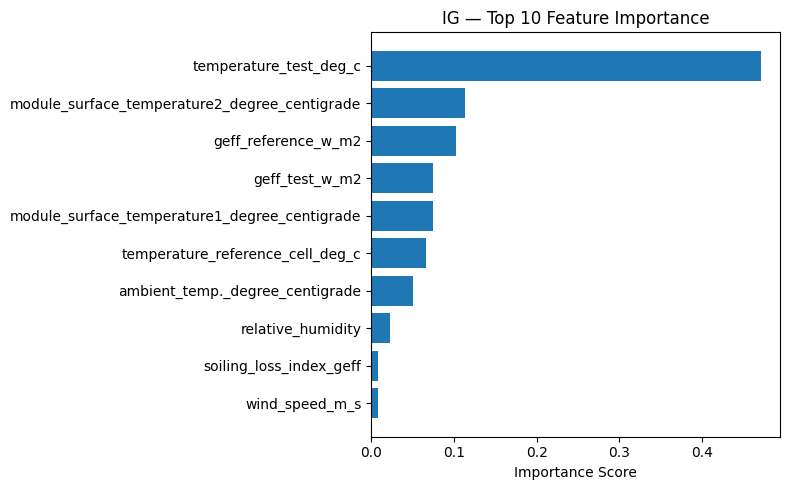


🚀 Training PCC model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

🔧 Best Hyperparameters Found:
   • subsample: 0.5
   • reg_lambda: 1.5
   • reg_alpha: 1.0
   • n_estimators: 200
   • min_child_weight: 5
   • max_depth: 4
   • learning_rate: 0.02
   • colsample_bytree: 0.7

📊 PCC Results (Overall):
   R² (Train): 0.9701 | R² (Test-Overall): 0.9874
   RMSE (Train): 19,543.89 | RMSE (Test-Overall): 14,982.36

☀️ PCC Results (Daylight-only TEST):
   R² (Test-Day): 0.9704 | RMSE (Test-Day): 19,540.31
   Status (based on Daylight): ✅ Good Fit (ΔRMSE=-0.02%)
💾 Saved PCC model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_pcc_spring.joblib


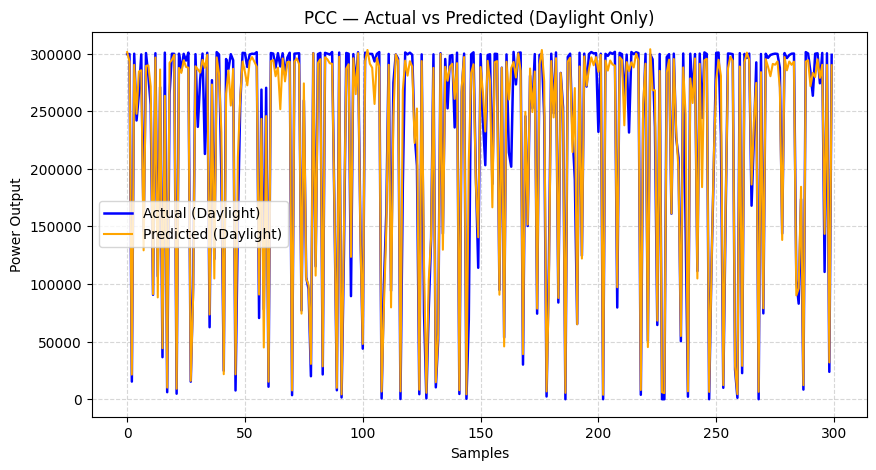

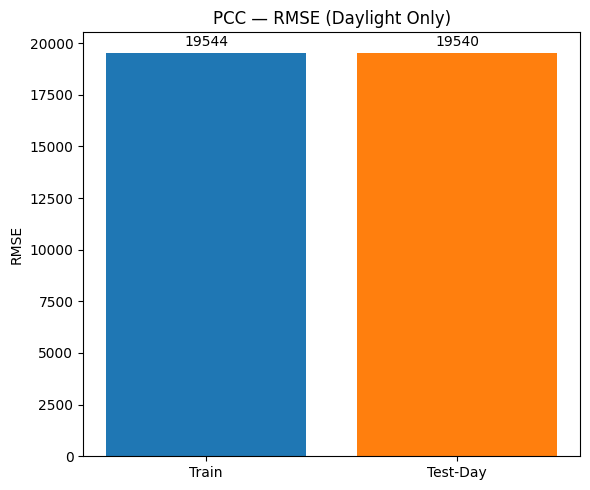

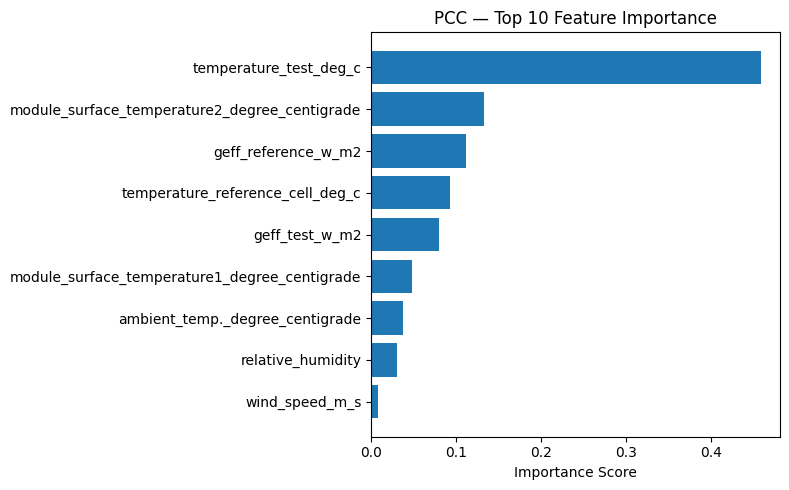


🏁 SPRING MODEL COMPARISON
IG → R²(Test-Day): 0.9716 | RMSE(Test-Day): 19166.3 | Status: ✅ Good Fit
PCC → R²(Test-Day): 0.9704 | RMSE(Test-Day): 19540.3 | Status: ✅ Good Fit

✅ IG performed better for SPRING (Daylight-based).
🏅 Best Hyperparameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'reg_alpha': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.7}
💾 Best model saved as → xgb_spring_best.joblib


In [42]:
# ============================================================
# 🌸 XGBoost Training & Visualization for SPRING (Anti-Overfit - Daylight Visualization)
# ============================================================

import pandas as pd, numpy as np, joblib, os, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
train_path = os.path.join(DATA_DIR, "all_data_spring_train_clean.h5")
test_path  = os.path.join(DATA_DIR, "all_data_spring_test_clean.h5")
features_path = os.path.join(DATA_DIR, "selected_features_spring_ig_pcc.joblib")

# -----------------------------
# 📊 Load data
# -----------------------------
print("📦 Loading training and testing data...")
train_df = pd.read_hdf(train_path, 'df')
test_df  = pd.read_hdf(test_path, 'df')
features = joblib.load(features_path)
print(f"✅ Train: {train_df.shape}, Test: {test_df.shape}")

target_col = train_df.columns[-1]
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

# -----------------------------
# 🚫 Remove nighttime samples (low irradiance ≈ 0)
# -----------------------------
irr_cols = [c for c in X_train.columns if any(k in c.lower() for k in ["ghi", "irradiance", "poa", "w_m2"])]
if irr_cols:
    mask_day = X_train[irr_cols].max(axis=1) > 1
    removed_rows = (~mask_day).sum()
    X_train = X_train[mask_day]
    y_train = y_train[mask_day]
    print(f"🌙 Removed {removed_rows:,} nighttime rows (irradiance < 1)")
else:
    print("⚠️ No irradiance-related columns found — skipped filtering.")

# -----------------------------
# ⚙️ Parameter Grid (Balanced)
# -----------------------------
param_grid = {
    "n_estimators": [80, 120, 150, 200],
    "learning_rate": [0.005, 0.01, 0.02],
    "max_depth": [3, 4],
    "subsample": [0.5, 0.6, 0.7],
    "colsample_bytree": [0.5, 0.6, 0.7],
    "reg_alpha": [0.5, 0.8, 1.0],
    "reg_lambda": [1.5, 2.0, 2.5, 3.0],
    "min_child_weight": [5, 7, 9]
}

# -----------------------------
# 🧠 Training Function
# -----------------------------
def train_and_evaluate(X_train, y_train, X_test, y_test, feature_set_name, feature_list):
    print(f"\n🚀 Training {feature_set_name} model...")

    model = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=25,
        cv=5,
        verbose=1,
        n_jobs=-1,
        scoring='r2',
        random_state=42
    )

    search.fit(X_train[feature_list], y_train)
    best_model = search.best_estimator_
    best_params = search.best_params_

    print("\n🔧 Best Hyperparameters Found:")
    for k, v in best_params.items():
        print(f"   • {k}: {v}")

    # 📊 Predictions
    y_pred_train = best_model.predict(X_train[feature_list])
    y_pred_test  = best_model.predict(X_test[feature_list])

    # --- Overall metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test_overall  = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test_overall  = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # --- Daylight-only (fair comparison)
    irr_cols_test = [c for c in X_test.columns if any(k in c.lower() for k in ["ghi","irradiance","poa","w_m2"])]
    if irr_cols_test:
        mask_day_test = X_test[irr_cols_test].max(axis=1) > 1
        y_test_day  = y_test[mask_day_test]
        y_pred_day  = y_pred_test[mask_day_test]

        if len(y_test_day) > 0:
            r2_test_day   = r2_score(y_test_day, y_pred_day)
            rmse_test_day = np.sqrt(mean_squared_error(y_test_day, y_pred_day))
        else:
            r2_test_day, rmse_test_day = np.nan, np.nan
    else:
        mask_day_test = None
        r2_test_day, rmse_test_day = np.nan, np.nan

    # --- Delta RMSE & Status
    if not np.isnan(rmse_test_day):
        delta_rmse = ((rmse_test_day - rmse_train) / rmse_train) * 100
    else:
        delta_rmse = ((rmse_test_overall - rmse_train) / rmse_train) * 100

    if delta_rmse > 30:
        status = "🚨 Overfitting!"
    elif delta_rmse < -10:
        status = "⚠️ Underfitting!"
    else:
        status = "✅ Good Fit"

    # -----------------------------
    # 🖨️ Report
    # -----------------------------
    print(f"\n📊 {feature_set_name} Results (Overall):")
    print(f"   R² (Train): {r2_train:.4f} | R² (Test-Overall): {r2_test_overall:.4f}")
    print(f"   RMSE (Train): {rmse_train:,.2f} | RMSE (Test-Overall): {rmse_test_overall:,.2f}")

    if not np.isnan(rmse_test_day):
        print(f"\n☀️ {feature_set_name} Results (Daylight-only TEST):")
        print(f"   R² (Test-Day): {r2_test_day:.4f} | RMSE (Test-Day): {rmse_test_day:,.2f}")
        print(f"   Status (based on Daylight): {status} (ΔRMSE={delta_rmse:.2f}%)")
    else:
        print(f"\n⚠️ Daylight mask not available on TEST — Status based on Overall: {status} (ΔRMSE={delta_rmse:.2f}%)")

    # 💾 Save model
    model_path = os.path.join(DATA_DIR, f"xgb_{feature_set_name.lower()}_spring.joblib")
    joblib.dump(best_model, model_path)
    print(f"💾 Saved {feature_set_name} model → {model_path}")

    # 🎨 Actual vs Predicted (Daylight only)
    plt.figure(figsize=(10,5))
    plt.plot(y_test_day.values[:300], label="Actual (Daylight)", color="blue", linewidth=1.8)
    plt.plot(y_pred_day[:300], label="Predicted (Daylight)", color="orange", linewidth=1.5)
    plt.title(f"{feature_set_name} — Actual vs Predicted (Daylight Only)")
    plt.xlabel("Samples")
    plt.ylabel("Power Output")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # 📊 RMSE (Train vs Test-Day)
    plt.figure(figsize=(6,5))
    bars = plt.bar(["Train","Test-Day"], [rmse_train, rmse_test_day], color=["#1f77b4","#ff7f0e"])
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x()+b.get_width()/2, h + 300, f"{h:.0f}", ha='center', fontsize=10)
    plt.title(f"{feature_set_name} — RMSE (Daylight Only)")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()

    # 🔍 Feature Importance
    plt.figure(figsize=(8,5))
    importance = best_model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    plt.barh(np.array(feature_list)[sorted_idx][:10][::-1],
             importance[sorted_idx][:10][::-1], color="#1f77b4")
    plt.title(f"{feature_set_name} — Top 10 Feature Importance")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

    return {
        "name": feature_set_name,
        "model": best_model,
        "best_params": best_params,
        "r2_train": r2_train,
        "r2_test_overall": r2_test_overall,
        "rmse_train": rmse_train,
        "rmse_test_overall": rmse_test_overall,
        "r2_test_day": r2_test_day,
        "rmse_test_day": rmse_test_day,
        "status": status
    }

# -----------------------------
# 🧪 Train both IG & PCC
# -----------------------------
ig_result = train_and_evaluate(X_train, y_train, X_test, y_test, "IG", features["ig"])
pcc_result = train_and_evaluate(X_train, y_train, X_test, y_test, "PCC", features["pcc"])

# -----------------------------
# 🏁 Compare and Save Best Model
# -----------------------------
print("\n===============================")
print("🏁 SPRING MODEL COMPARISON")
print("===============================")
print(f"IG → R²(Test-Day): {ig_result['r2_test_day']:.4f} | RMSE(Test-Day): {ig_result['rmse_test_day']:.1f} | Status: {ig_result['status']}")
print(f"PCC → R²(Test-Day): {pcc_result['r2_test_day']:.4f} | RMSE(Test-Day): {pcc_result['rmse_test_day']:.1f} | Status: {pcc_result['status']}")

if ig_result['r2_test_day'] > pcc_result['r2_test_day']:
    print("\n✅ IG performed better for SPRING (Daylight-based).")
    print(f"🏅 Best Hyperparameters: {ig_result['best_params']}")
    joblib.dump(ig_result["model"], os.path.join(DATA_DIR, "xgb_spring_best.joblib"))
else:
    print("\n✅ PCC performed better for SPRING (Daylight-based).")
    print(f"🏅 Best Hyperparameters: {pcc_result['best_params']}")
    joblib.dump(pcc_result["model"], os.path.join(DATA_DIR, "xgb_spring_best.joblib"))

print("💾 Best model saved as → xgb_spring_best.joblib")


📦 Loading training and testing data...
✅ Train: (105962, 20), Test: (26491, 20)
🌙 Removed 43,616 nighttime rows (irradiance < 1)

🚀 Training IG model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

🔧 Best Hyperparameters Found:
   • subsample: 0.5
   • reg_lambda: 1.5
   • reg_alpha: 1.0
   • n_estimators: 200
   • min_child_weight: 5
   • max_depth: 4
   • learning_rate: 0.02
   • colsample_bytree: 0.7

📊 IG Results (Overall):
   R² (Train): 0.9747 | R² (Test-Overall): 0.9826
   RMSE (Train): 17,299.62 | RMSE (Test-Overall): 18,326.26

☀️ IG Results (Daylight-only TEST):
   R² (Test-Day): 0.9730 | RMSE (Test-Day): 17,864.23
   Status (based on Daylight): ✅ Good Fit (ΔRMSE=3.26%)
💾 Saved IG model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_ig_summer.joblib


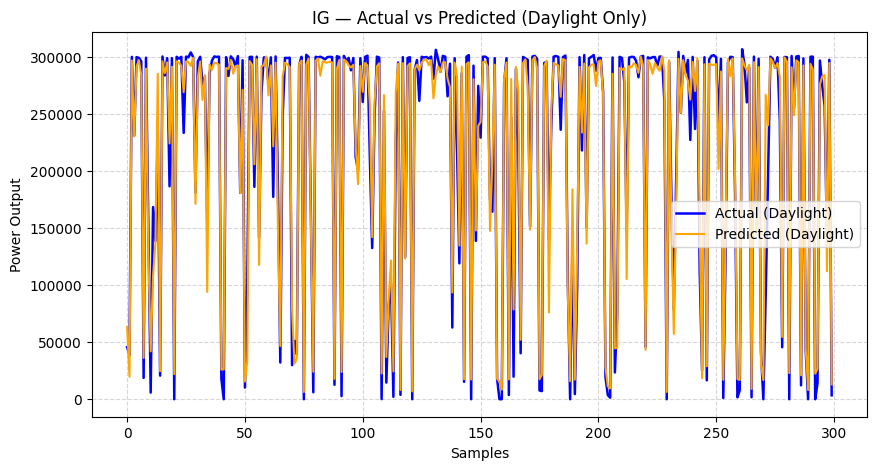

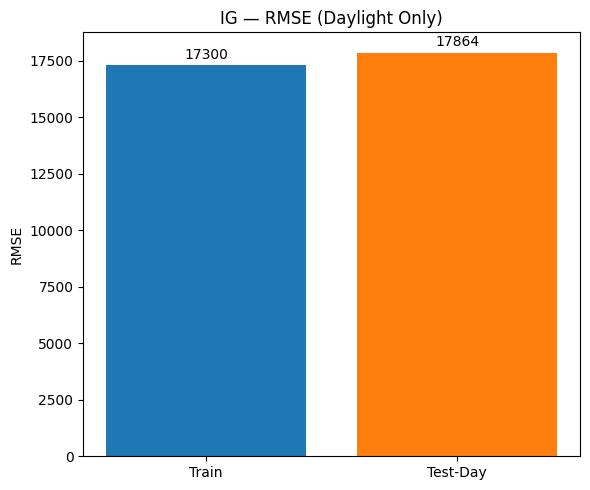

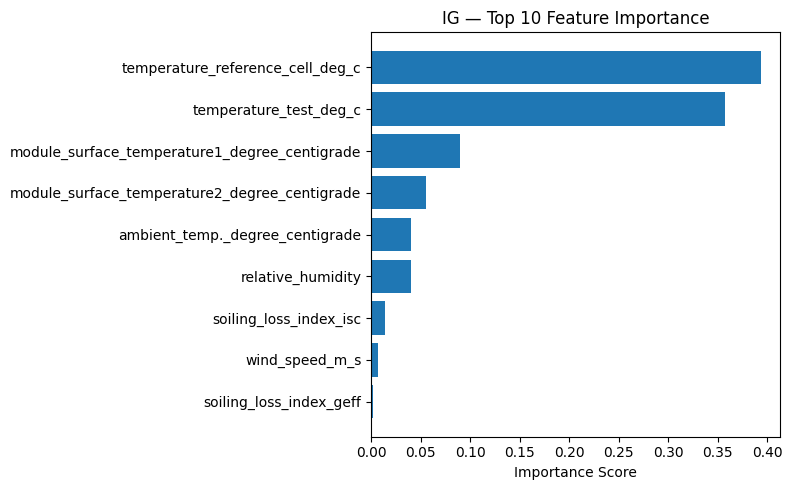


🚀 Training PCC model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

🔧 Best Hyperparameters Found:
   • subsample: 0.6
   • reg_lambda: 2.5
   • reg_alpha: 0.5
   • n_estimators: 200
   • min_child_weight: 7
   • max_depth: 4
   • learning_rate: 0.02
   • colsample_bytree: 0.7

📊 PCC Results (Overall):
   R² (Train): 0.9728 | R² (Test-Overall): 0.9811
   RMSE (Train): 17,933.68 | RMSE (Test-Overall): 19,104.47

☀️ PCC Results (Daylight-only TEST):
   R² (Test-Day): 0.9709 | RMSE (Test-Day): 18,560.70
   Status (based on Daylight): ✅ Good Fit (ΔRMSE=3.50%)
💾 Saved PCC model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_pcc_summer.joblib


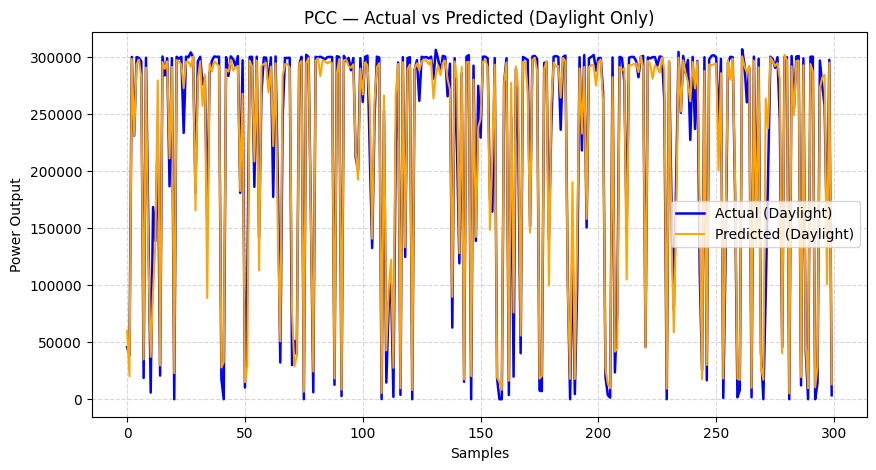

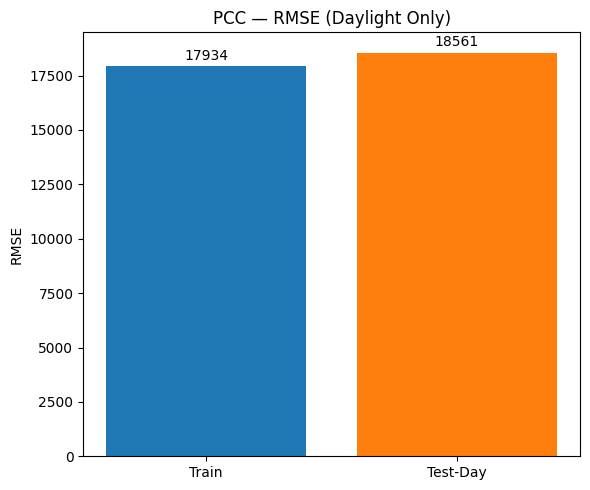

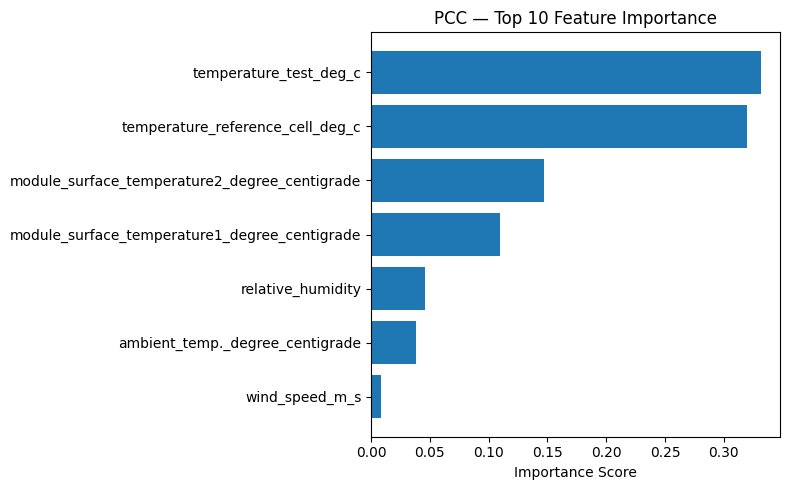


🏁 SUMMER MODEL COMPARISON
IG → R²(Test-Day): 0.9730 | RMSE(Test-Day): 17864.2 | Status: ✅ Good Fit
PCC → R²(Test-Day): 0.9709 | RMSE(Test-Day): 18560.7 | Status: ✅ Good Fit

✅ IG performed better for SUMMER (Daylight-based).
🏅 Best Hyperparameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'reg_alpha': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.7}
💾 Best model saved as → xgb_summer_best.joblib


In [41]:
# ============================================================
# ☀️ XGBoost Training & Visualization for SUMMER (Anti-Overfit - Daylight Visualization)
# ============================================================

import pandas as pd, numpy as np, joblib, os, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
train_path = os.path.join(DATA_DIR, "all_data_summer_train_clean.h5")
test_path  = os.path.join(DATA_DIR, "all_data_summer_test_clean.h5")
features_path = os.path.join(DATA_DIR, "selected_features_summer_ig_pcc.joblib")

# -----------------------------
# 📊 Load data
# -----------------------------
print("📦 Loading training and testing data...")
train_df = pd.read_hdf(train_path, 'df')
test_df  = pd.read_hdf(test_path, 'df')
features = joblib.load(features_path)
print(f"✅ Train: {train_df.shape}, Test: {test_df.shape}")

target_col = train_df.columns[-1]
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

# -----------------------------
# 🚫 Remove nighttime samples (low irradiance ≈ 0)
# -----------------------------
irr_cols = [c for c in X_train.columns if any(k in c.lower() for k in ["ghi", "irradiance", "poa", "w_m2"])]
if irr_cols:
    mask_day = X_train[irr_cols].max(axis=1) > 1
    removed_rows = (~mask_day).sum()
    X_train = X_train[mask_day]
    y_train = y_train[mask_day]
    print(f"🌙 Removed {removed_rows:,} nighttime rows (irradiance < 1)")
else:
    print("⚠️ No irradiance-related columns found — skipped filtering.")

# -----------------------------
# ⚙️ Parameter Grid (Balanced)
# -----------------------------
param_grid = {
    "n_estimators": [80, 120, 150, 200],
    "learning_rate": [0.005, 0.01, 0.02],
    "max_depth": [3, 4],
    "subsample": [0.5, 0.6, 0.7],
    "colsample_bytree": [0.5, 0.6, 0.7],
    "reg_alpha": [0.5, 0.8, 1.0],
    "reg_lambda": [1.5, 2.0, 2.5, 3.0],
    "min_child_weight": [5, 7, 9]
}

# -----------------------------
# 🧠 Training Function
# -----------------------------
def train_and_evaluate(X_train, y_train, X_test, y_test, feature_set_name, feature_list):
    print(f"\n🚀 Training {feature_set_name} model...")

    model = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=25,
        cv=5,
        verbose=1,
        n_jobs=-1,
        scoring='r2',
        random_state=42
    )

    search.fit(X_train[feature_list], y_train)
    best_model = search.best_estimator_
    best_params = search.best_params_

    print("\n🔧 Best Hyperparameters Found:")
    for k, v in best_params.items():
        print(f"   • {k}: {v}")

    # 📊 Predictions
    y_pred_train = best_model.predict(X_train[feature_list])
    y_pred_test  = best_model.predict(X_test[feature_list])

    # --- Overall metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test_overall  = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test_overall  = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # --- Daylight-only metrics
    irr_cols_test = [c for c in X_test.columns if any(k in c.lower() for k in ["ghi","irradiance","poa","w_m2"])]
    if irr_cols_test:
        mask_day_test = X_test[irr_cols_test].max(axis=1) > 1
        y_test_day  = y_test[mask_day_test]
        y_pred_day  = y_pred_test[mask_day_test]

        if len(y_test_day) > 0:
            r2_test_day   = r2_score(y_test_day, y_pred_day)
            rmse_test_day = np.sqrt(mean_squared_error(y_test_day, y_pred_day))
        else:
            r2_test_day, rmse_test_day = np.nan, np.nan
    else:
        mask_day_test = None
        r2_test_day, rmse_test_day = np.nan, np.nan

    # --- Delta RMSE & Status
    if not np.isnan(rmse_test_day):
        delta_rmse = ((rmse_test_day - rmse_train) / rmse_train) * 100
    else:
        delta_rmse = ((rmse_test_overall - rmse_train) / rmse_train) * 100

    if delta_rmse > 30:
        status = "🚨 Overfitting!"
    elif delta_rmse < -10:
        status = "⚠️ Underfitting!"
    else:
        status = "✅ Good Fit"

    # -----------------------------
    # 🖨️ Report
    # -----------------------------
    print(f"\n📊 {feature_set_name} Results (Overall):")
    print(f"   R² (Train): {r2_train:.4f} | R² (Test-Overall): {r2_test_overall:.4f}")
    print(f"   RMSE (Train): {rmse_train:,.2f} | RMSE (Test-Overall): {rmse_test_overall:,.2f}")

    if not np.isnan(rmse_test_day):
        print(f"\n☀️ {feature_set_name} Results (Daylight-only TEST):")
        print(f"   R² (Test-Day): {r2_test_day:.4f} | RMSE (Test-Day): {rmse_test_day:,.2f}")
        print(f"   Status (based on Daylight): {status} (ΔRMSE={delta_rmse:.2f}%)")
    else:
        print(f"\n⚠️ Daylight mask not available on TEST — Status based on Overall: {status} (ΔRMSE={delta_rmse:.2f}%)")

    # 💾 Save model
    model_path = os.path.join(DATA_DIR, f"xgb_{feature_set_name.lower()}_summer.joblib")
    joblib.dump(best_model, model_path)
    print(f"💾 Saved {feature_set_name} model → {model_path}")

    # 🎨 Actual vs Predicted (Daylight only)
    plt.figure(figsize=(10,5))
    plt.plot(y_test_day.values[:300], label="Actual (Daylight)", color="blue", linewidth=1.8)
    plt.plot(y_pred_day[:300], label="Predicted (Daylight)", color="orange", linewidth=1.5)
    plt.title(f"{feature_set_name} — Actual vs Predicted (Daylight Only)")
    plt.xlabel("Samples")
    plt.ylabel("Power Output")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # 📊 RMSE (Train vs Test-Day)
    plt.figure(figsize=(6,5))
    bars = plt.bar(["Train","Test-Day"], [rmse_train, rmse_test_day], color=["#1f77b4","#ff7f0e"])
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x()+b.get_width()/2, h + 300, f"{h:.0f}", ha='center', fontsize=10)
    plt.title(f"{feature_set_name} — RMSE (Daylight Only)")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()

    # 🔍 Feature Importance
    plt.figure(figsize=(8,5))
    importance = best_model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    plt.barh(np.array(feature_list)[sorted_idx][:10][::-1],
             importance[sorted_idx][:10][::-1], color="#1f77b4")
    plt.title(f"{feature_set_name} — Top 10 Feature Importance")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

    return {
        "name": feature_set_name,
        "model": best_model,
        "best_params": best_params,
        "r2_train": r2_train,
        "r2_test_overall": r2_test_overall,
        "rmse_train": rmse_train,
        "rmse_test_overall": rmse_test_overall,
        "r2_test_day": r2_test_day,
        "rmse_test_day": rmse_test_day,
        "status": status
    }

# -----------------------------
# 🧪 Train both IG & PCC
# -----------------------------
ig_result = train_and_evaluate(X_train, y_train, X_test, y_test, "IG", features["ig"])
pcc_result = train_and_evaluate(X_train, y_train, X_test, y_test, "PCC", features["pcc"])

# -----------------------------
# 🏁 Compare and Save Best Model
# -----------------------------
print("\n===============================")
print("🏁 SUMMER MODEL COMPARISON")
print("===============================")
print(f"IG → R²(Test-Day): {ig_result['r2_test_day']:.4f} | RMSE(Test-Day): {ig_result['rmse_test_day']:.1f} | Status: {ig_result['status']}")
print(f"PCC → R²(Test-Day): {pcc_result['r2_test_day']:.4f} | RMSE(Test-Day): {pcc_result['rmse_test_day']:.1f} | Status: {pcc_result['status']}")

if ig_result['r2_test_day'] > pcc_result['r2_test_day']:
    print("\n✅ IG performed better for SUMMER (Daylight-based).")
    print(f"🏅 Best Hyperparameters: {ig_result['best_params']}")
    joblib.dump(ig_result["model"], os.path.join(DATA_DIR, "xgb_summer_best.joblib"))
else:
    print("\n✅ PCC performed better for SUMMER (Daylight-based).")
    print(f"🏅 Best Hyperparameters: {pcc_result['best_params']}")
    joblib.dump(pcc_result["model"], os.path.join(DATA_DIR, "xgb_summer_best.joblib"))

print("💾 Best model saved as → xgb_summer_best.joblib")


📦 Loading training and testing data...
✅ Train: (104780, 20), Test: (26196, 20)
🌙 Removed 53,077 nighttime rows (irradiance < 1)

🚀 Training IG model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

🔧 Best Hyperparameters Found:
   • subsample: 0.5
   • reg_lambda: 1.5
   • reg_alpha: 1.0
   • n_estimators: 200
   • min_child_weight: 5
   • max_depth: 4
   • learning_rate: 0.02
   • colsample_bytree: 0.7

📊 IG Results (Overall):
   R² (Train): 0.9569 | R² (Test-Overall): 0.9712
   RMSE (Train): 21,323.85 | RMSE (Test-Overall): 20,309.90

☀️ IG Results (Daylight-only TEST):
   R² (Test-Day): 0.9567 | RMSE (Test-Day): 21,514.61
   Status (based on Daylight): ✅ Good Fit (ΔRMSE=0.89%)
💾 Saved IG model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_ig_fall.joblib


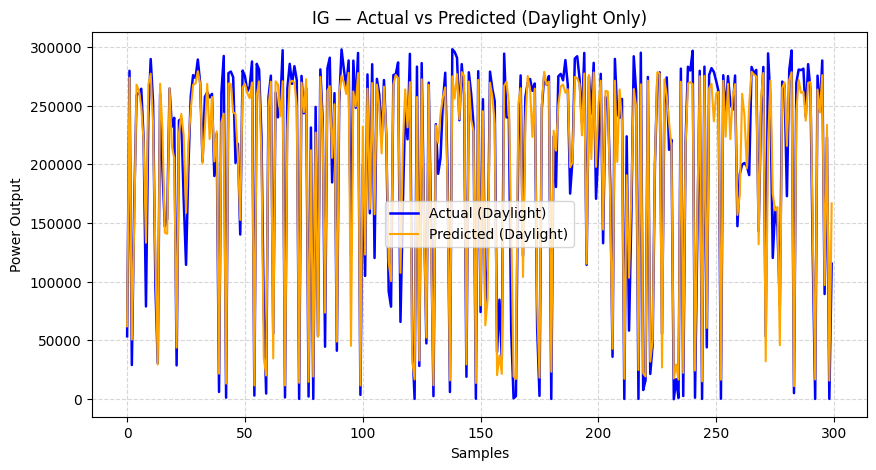

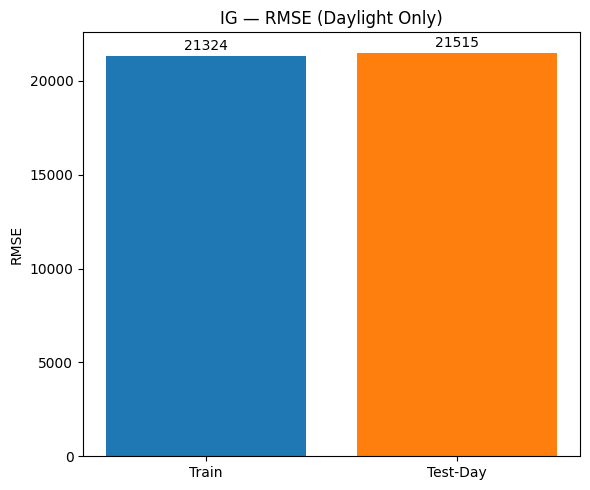

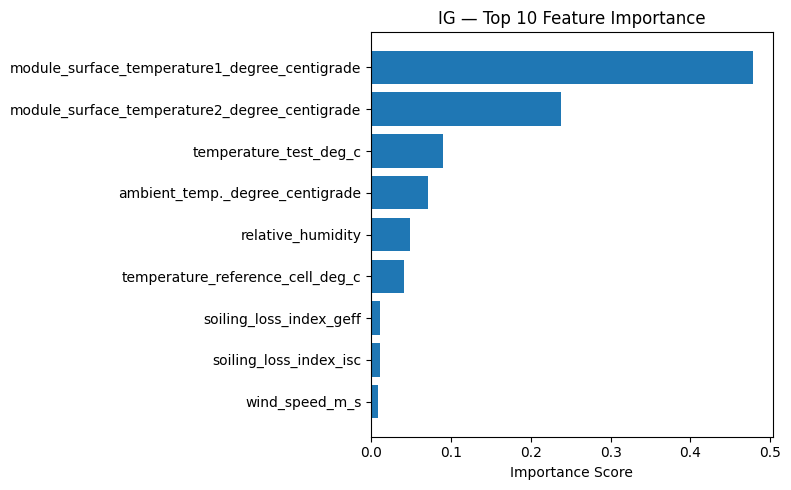


🚀 Training PCC model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

🔧 Best Hyperparameters Found:
   • subsample: 0.5
   • reg_lambda: 1.5
   • reg_alpha: 1.0
   • n_estimators: 200
   • min_child_weight: 5
   • max_depth: 4
   • learning_rate: 0.02
   • colsample_bytree: 0.7

📊 PCC Results (Overall):
   R² (Train): 0.9514 | R² (Test-Overall): 0.9691
   RMSE (Train): 22,629.78 | RMSE (Test-Overall): 21,030.54

☀️ PCC Results (Daylight-only TEST):
   R² (Test-Day): 0.9509 | RMSE (Test-Day): 22,907.78
   Status (based on Daylight): ✅ Good Fit (ΔRMSE=1.23%)
💾 Saved PCC model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_pcc_fall.joblib


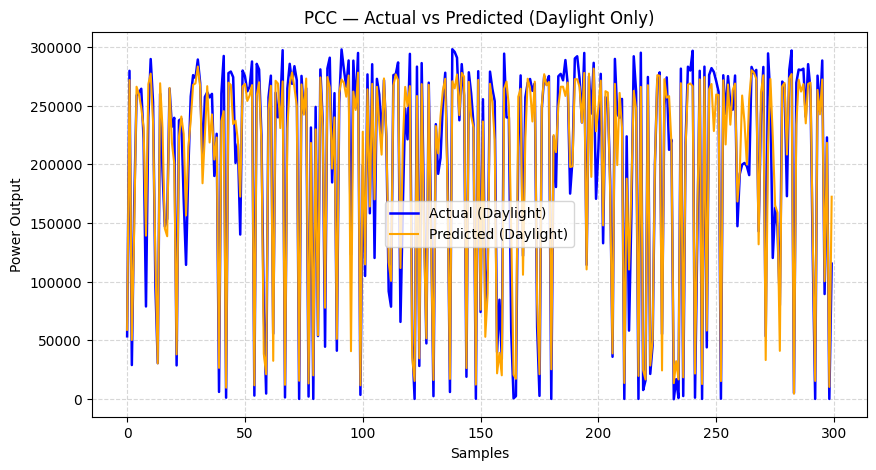

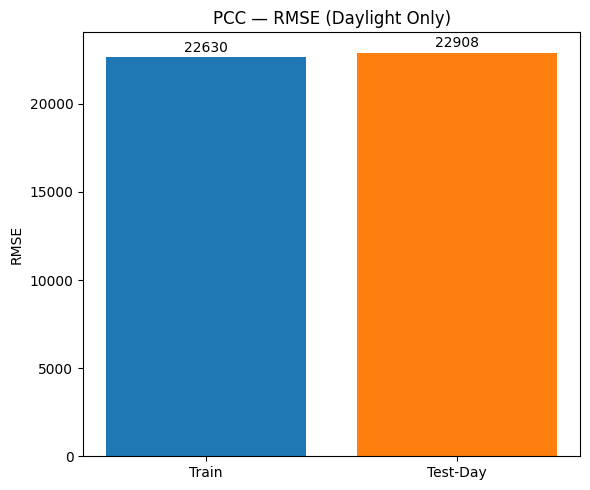

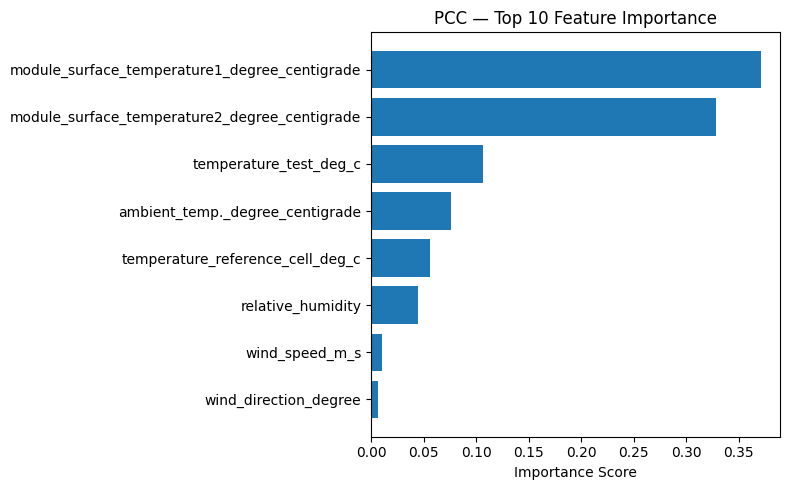


🏁 FALL MODEL COMPARISON
IG → R²(Test-Day): 0.9567 | RMSE(Test-Day): 21514.6 | Status: ✅ Good Fit
PCC → R²(Test-Day): 0.9509 | RMSE(Test-Day): 22907.8 | Status: ✅ Good Fit

✅ IG performed better for FALL (Daylight-based).
🏅 Best Hyperparameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'reg_alpha': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.7}
💾 Best model saved as → xgb_fall_best.joblib


In [40]:
# ============================================================
# 🍂 XGBoost Training & Visualization for FALL (Anti-Overfit - Daylight Visualization)
# ============================================================

import pandas as pd, numpy as np, joblib, os, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
train_path = os.path.join(DATA_DIR, "all_data_fall_train_clean.h5")
test_path  = os.path.join(DATA_DIR, "all_data_fall_test_clean.h5")
features_path = os.path.join(DATA_DIR, "selected_features_fall_ig_pcc.joblib")

# -----------------------------
# 📊 Load data
# -----------------------------
print("📦 Loading training and testing data...")
train_df = pd.read_hdf(train_path, 'df')
test_df  = pd.read_hdf(test_path, 'df')
features = joblib.load(features_path)
print(f"✅ Train: {train_df.shape}, Test: {test_df.shape}")

target_col = train_df.columns[-1]
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

# -----------------------------
# 🚫 Remove nighttime samples (low irradiance ≈ 0)
# -----------------------------
irr_cols = [c for c in X_train.columns if any(k in c.lower() for k in ["ghi", "irradiance", "poa", "w_m2"])]
if irr_cols:
    mask_day = X_train[irr_cols].max(axis=1) > 1
    removed_rows = (~mask_day).sum()
    X_train = X_train[mask_day]
    y_train = y_train[mask_day]
    print(f"🌙 Removed {removed_rows:,} nighttime rows (irradiance < 1)")
else:
    print("⚠️ No irradiance-related columns found — skipped filtering.")

# -----------------------------
# ⚙️ Parameter Grid (Balanced)
# -----------------------------
param_grid = {
    "n_estimators": [80, 120, 150, 200],
    "learning_rate": [0.005, 0.01, 0.02],
    "max_depth": [3, 4],
    "subsample": [0.5, 0.6, 0.7],
    "colsample_bytree": [0.5, 0.6, 0.7],
    "reg_alpha": [0.5, 0.8, 1.0],
    "reg_lambda": [1.5, 2.0, 2.5, 3.0],
    "min_child_weight": [5, 7, 9]
}

# -----------------------------
# 🧠 Training Function
# -----------------------------
def train_and_evaluate(X_train, y_train, X_test, y_test, feature_set_name, feature_list):
    print(f"\n🚀 Training {feature_set_name} model...")

    model = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=25,
        cv=5,
        verbose=1,
        n_jobs=-1,
        scoring='r2',
        random_state=42
    )

    search.fit(X_train[feature_list], y_train)
    best_model = search.best_estimator_
    best_params = search.best_params_

    print("\n🔧 Best Hyperparameters Found:")
    for k, v in best_params.items():
        print(f"   • {k}: {v}")

    # 📊 Predictions
    y_pred_train = best_model.predict(X_train[feature_list])
    y_pred_test  = best_model.predict(X_test[feature_list])

    # --- Overall metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test_overall  = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test_overall  = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # --- Daylight-only (fair comparison)
    irr_cols_test = [c for c in X_test.columns if any(k in c.lower() for k in ["ghi","irradiance","poa","w_m2"])]
    if irr_cols_test:
        mask_day_test = X_test[irr_cols_test].max(axis=1) > 1
        y_test_day  = y_test[mask_day_test]
        y_pred_day  = y_pred_test[mask_day_test]

        if len(y_test_day) > 0:
            r2_test_day   = r2_score(y_test_day, y_pred_day)
            rmse_test_day = np.sqrt(mean_squared_error(y_test_day, y_pred_day))
        else:
            r2_test_day, rmse_test_day = np.nan, np.nan
    else:
        mask_day_test = None
        r2_test_day, rmse_test_day = np.nan, np.nan

    if not np.isnan(rmse_test_day):
        delta_rmse = ((rmse_test_day - rmse_train) / rmse_train) * 100
    else:
        delta_rmse = ((rmse_test_overall - rmse_train) / rmse_train) * 100

    if delta_rmse > 30:
        status = "🚨 Overfitting!"
    elif delta_rmse < -10:
        status = "⚠️ Underfitting!"
    else:
        status = "✅ Good Fit"

    # -----------------------------
    # 🖨️ Report
    # -----------------------------
    print(f"\n📊 {feature_set_name} Results (Overall):")
    print(f"   R² (Train): {r2_train:.4f} | R² (Test-Overall): {r2_test_overall:.4f}")
    print(f"   RMSE (Train): {rmse_train:,.2f} | RMSE (Test-Overall): {rmse_test_overall:,.2f}")

    if not np.isnan(rmse_test_day):
        print(f"\n☀️ {feature_set_name} Results (Daylight-only TEST):")
        print(f"   R² (Test-Day): {r2_test_day:.4f} | RMSE (Test-Day): {rmse_test_day:,.2f}")
        print(f"   Status (based on Daylight): {status} (ΔRMSE={delta_rmse:.2f}%)")
    else:
        print(f"\n⚠️ Daylight mask not available on TEST — Status based on Overall: {status} (ΔRMSE={delta_rmse:.2f}%)")

    # 💾 Save model
    model_path = os.path.join(DATA_DIR, f"xgb_{feature_set_name.lower()}_fall.joblib")
    joblib.dump(best_model, model_path)
    print(f"💾 Saved {feature_set_name} model → {model_path}")

    # 🎨 Plot (Daylight only)
    plt.figure(figsize=(10,5))
    plt.plot(y_test_day.values[:300], label="Actual (Daylight)", color="blue", linewidth=1.8)
    plt.plot(y_pred_day[:300], label="Predicted (Daylight)", color="orange", linewidth=1.5)
    plt.title(f"{feature_set_name} — Actual vs Predicted (Daylight Only)")
    plt.xlabel("Samples")
    plt.ylabel("Power Output")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # 📊 RMSE (Daylight Only)
    plt.figure(figsize=(6,5))
    bars = plt.bar(["Train","Test-Day"], [rmse_train, rmse_test_day], color=["#1f77b4","#ff7f0e"])
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x()+b.get_width()/2, h + 300, f"{h:.0f}", ha='center', fontsize=10)
    plt.title(f"{feature_set_name} — RMSE (Daylight Only)")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()

    # 🔍 Feature Importance
    plt.figure(figsize=(8,5))
    importance = best_model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    plt.barh(np.array(feature_list)[sorted_idx][:10][::-1],
             importance[sorted_idx][:10][::-1], color="#1f77b4")
    plt.title(f"{feature_set_name} — Top 10 Feature Importance")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

    return {
        "name": feature_set_name,
        "model": best_model,
        "best_params": best_params,
        "r2_train": r2_train,
        "r2_test_overall": r2_test_overall,
        "rmse_train": rmse_train,
        "rmse_test_overall": rmse_test_overall,
        "r2_test_day": r2_test_day,
        "rmse_test_day": rmse_test_day,
        "status": status
    }

# -----------------------------
# 🧪 Train both IG & PCC
# -----------------------------
ig_result = train_and_evaluate(X_train, y_train, X_test, y_test, "IG", features["ig"])
pcc_result = train_and_evaluate(X_train, y_train, X_test, y_test, "PCC", features["pcc"])

# -----------------------------
# 🏁 Compare and Save Best Model
# -----------------------------
print("\n===============================")
print("🏁 FALL MODEL COMPARISON")
print("===============================")
print(f"IG → R²(Test-Day): {ig_result['r2_test_day']:.4f} | RMSE(Test-Day): {ig_result['rmse_test_day']:.1f} | Status: {ig_result['status']}")
print(f"PCC → R²(Test-Day): {pcc_result['r2_test_day']:.4f} | RMSE(Test-Day): {pcc_result['rmse_test_day']:.1f} | Status: {pcc_result['status']}")

if ig_result['r2_test_day'] > pcc_result['r2_test_day']:
    print("\n✅ IG performed better for FALL (Daylight-based).")
    print(f"🏅 Best Hyperparameters: {ig_result['best_params']}")
    joblib.dump(ig_result["model"], os.path.join(DATA_DIR, "xgb_fall_best.joblib"))
else:
    print("\n✅ PCC performed better for FALL (Daylight-based).")
    print(f"🏅 Best Hyperparameters: {pcc_result['best_params']}")
    joblib.dump(pcc_result["model"], os.path.join(DATA_DIR, "xgb_fall_best.joblib"))

print("💾 Best model saved as → xgb_fall_best.joblib")


In [1]:
# ============================================================
# 🎲 Display 10 Random Actual vs Predicted Samples (Train & Test per Season)
# ============================================================

import random
import pandas as pd
import joblib
import os
import numpy as np

pd.set_option("display.precision", 4)

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
seasons = ["winter", "spring", "summer", "fall"]

for season in seasons:
    print("\n" + "="*70)
    print(f"🌤️ Random 10 Actual vs Predicted Samples — {season.upper()}")
    print("="*70)

    best_model_path = os.path.join(DATA_DIR, f"xgb_{season}.joblib")
    train_path = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    test_path  = os.path.join(DATA_DIR, f"all_data_{season}_test_clean.h5")

    if not os.path.exists(best_model_path):
        print(f"⚠️ No trained model found for {season.upper()} — skipping.")
        continue

    # Load model and data
    model = joblib.load(best_model_path)
    train_df = pd.read_hdf(train_path, 'df')
    test_df  = pd.read_hdf(test_path, 'df')

    # Drop datetime columns
    datetime_cols = train_df.select_dtypes(include=['datetime64']).columns.tolist()
    if datetime_cols:
        print(f"🕒 Dropping datetime columns: {datetime_cols}")
        train_df = train_df.drop(columns=datetime_cols, errors='ignore')
        test_df  = test_df.drop(columns=datetime_cols, errors='ignore')

    X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

    # ✅ Match feature names with model
    if hasattr(model, "feature_names_in_"):
        features_used = model.feature_names_in_
        X_train = X_train[features_used]
        X_test  = X_test[features_used]

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Select 10 random indices
    train_idx = random.sample(range(len(y_train)), 10)
    test_idx  = random.sample(range(len(y_test)), 10)

    # --- TRAIN SAMPLE ---
    print("\n--- TRAIN SAMPLE (10 random) ---")
    df_train_sample = pd.DataFrame({
        "Actual": y_train.iloc[train_idx].values,
        "Predicted": y_pred_train[train_idx],
        "Abs_Error": np.abs(y_train.iloc[train_idx].values - y_pred_train[train_idx])
    })
    print(df_train_sample.to_string(index=False))

    # --- TEST SAMPLE ---
    print("\n--- TEST SAMPLE (10 random) ---")
    df_test_sample = pd.DataFrame({
        "Actual": y_test.iloc[test_idx].values,
        "Predicted": y_pred_test[test_idx],
        "Abs_Error": np.abs(y_test.iloc[test_idx].values - y_pred_test[test_idx])
    })
    print(df_test_sample.to_string(index=False))

    # 📊 Print mean absolute error
    mean_error = np.mean(np.abs(y_test.values - y_pred_test))
    print(f"\n📈 Mean Absolute Error (Test): {mean_error:.2f}")

    print("\n" + "="*70)



🌤️ Random 10 Actual vs Predicted Samples — WINTER
🕒 Dropping datetime columns: ['time']

--- TRAIN SAMPLE (10 random) ---
    Actual   Predicted  Abs_Error
     0.000   7059.9556  7059.9556
248094.970 232409.7812 15685.1888
     0.000  20697.5703 20697.5703
271096.940 264085.9375  7011.0025
244570.750 251720.6094  7149.8594
     0.000  20021.8984 20021.8984
  -876.147  26208.2266 27084.3736
     0.000  18641.0273 18641.0273
     0.000  20021.8984 20021.8984
 24703.867  34559.8750  9856.0080

--- TEST SAMPLE (10 random) ---
   Actual   Predicted  Abs_Error
118333.85  96556.9531 21776.8969
     0.00  20512.4746 20512.4746
     0.00  16402.5723 16402.5723
     0.00  19377.3047 19377.3047
     0.00  13516.5303 13516.5303
151597.61 157831.1875  6233.5775
     0.00  14398.0566 14398.0566
     0.00  14358.1221 14358.1221
     0.00  13516.5303 13516.5303
  3656.81   7203.3335  3546.5235

📈 Mean Absolute Error (Test): 16242.29


🌤️ Random 10 Actual vs Predicted Samples — SPRING
🕒 Dropping date

In [47]:
# ============================================================
# 🎲 Display 10 Random Actual vs Predicted Samples (Train & Test per Season) — Daylight Only
# ============================================================

import random
import pandas as pd
import joblib
import os
import numpy as np

pd.set_option("display.precision", 4)

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
seasons = ["winter", "spring", "summer", "fall"]

for season in seasons:
    print("\n" + "="*70)
    print(f"🌤️ Random 10 Actual vs Predicted Samples — {season.upper()} (Daylight Only)")
    print("="*70)

    best_model_path = os.path.join(DATA_DIR, f"xgb_{season}.joblib")
    train_path = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    test_path  = os.path.join(DATA_DIR, f"all_data_{season}_test_clean.h5")

    if not os.path.exists(best_model_path):
        print(f"⚠️ No trained model found for {season.upper()} — skipping.")
        continue

    # Load model and data
    model = joblib.load(best_model_path)
    train_df = pd.read_hdf(train_path, 'df')
    test_df  = pd.read_hdf(test_path, 'df')

    # Drop datetime columns
    datetime_cols = train_df.select_dtypes(include=['datetime64']).columns.tolist()
    if datetime_cols:
        print(f"🕒 Dropping datetime columns: {datetime_cols}")
        train_df = train_df.drop(columns=datetime_cols, errors='ignore')
        test_df  = test_df.drop(columns=datetime_cols, errors='ignore')

    X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

    # ☀️ Filter daylight only (irradiance > 1)
    irr_cols = [c for c in X_test.columns if any(k in c.lower() for k in ["ghi", "irradiance", "poa", "w_m2"])]
    if irr_cols:
        mask_day = X_test[irr_cols].max(axis=1) > 1
        before = len(X_test)
        X_test = X_test[mask_day].copy()
        y_test = y_test[mask_day].copy()
        print(f"☀️ Daylight-only TEST rows kept: {len(y_test):,} / {before:,}")
    else:
        print("⚠️ No irradiance columns found — skipping daylight filter.")

    # ✅ Match feature names with model
    if hasattr(model, "feature_names_in_"):
        features_used = model.feature_names_in_
        X_train = X_train[features_used]
        X_test  = X_test[features_used]

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Select 10 random indices
    train_idx = random.sample(range(len(y_train)), 10)
    test_idx  = random.sample(range(len(y_test)), 10)

    # --- TRAIN SAMPLE ---
    print("\n--- TRAIN SAMPLE (10 random) ---")
    df_train_sample = pd.DataFrame({
        "Actual": y_train.iloc[train_idx].values,
        "Predicted": y_pred_train[train_idx],
        "Abs_Error": np.abs(y_train.iloc[train_idx].values - y_pred_train[train_idx])
    })
    print(df_train_sample.to_string(index=False))

    # --- TEST SAMPLE (Daylight Only) ---
    print("\n--- TEST SAMPLE (10 random, Daylight Only) ---")
    df_test_sample = pd.DataFrame({
        "Actual": y_test.iloc[test_idx].values,
        "Predicted": y_pred_test[test_idx],
        "Abs_Error": np.abs(y_test.iloc[test_idx].values - y_pred_test[test_idx])
    })
    print(df_test_sample.to_string(index=False))

    # 📊 Print mean absolute error
    mean_error = np.mean(np.abs(y_test.values - y_pred_test))
    print(f"\n📈 Mean Absolute Error (Test, Daylight Only): {mean_error:.2f}")

    print("\n" + "="*70)



🌤️ Random 10 Actual vs Predicted Samples — WINTER (Daylight Only)
🕒 Dropping datetime columns: ['time']
☀️ Daylight-only TEST rows kept: 11,983 / 25,979

--- TRAIN SAMPLE (10 random) ---
     Actual   Predicted  Abs_Error
  5966.3643  10354.8262  4388.4619
     0.0000  14746.3711 14746.3711
300228.2500 287200.1250 13028.1250
238426.6400 232358.6094  6068.0306
     0.0000  23969.4805 23969.4805
     0.0000  18623.9570 18623.9570
224475.7500 231030.8281  6555.0781
243785.6400 232155.8281 11629.8119
 48034.7770  84409.5156 36374.7386
246722.1400 246489.5781   232.5619

--- TEST SAMPLE (10 random, Daylight Only) ---
    Actual   Predicted   Abs_Error
118683.530 245030.5156 126346.9856
 21428.031  41084.3281  19656.2971
235060.160 244533.2656   9473.1056
233430.250 237947.5938   4517.3438
 96934.820  80562.3359  16372.4841
273271.700 268937.8438   4333.8563
 81359.950 116126.3750  34766.4250
266671.720 247867.8125  18803.9075
120853.900 106627.3828  14226.5172
153334.560 145870.2344   7464

In [2]:
# ============================================================
# 📊 Automatic System Capacity & RMSE Evaluation per Season
# ============================================================

import pandas as pd
import numpy as np
import os

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = "/Users/shthaz/Desktop/Solar_Panels2/Data"
seasons = ["winter", "spring", "summer", "fall"]

# --- RMSE results from your models (replace with actual) ---
rmse_values = {
    "winter": 21955.35,
    "spring": 19166.32,
    "summer": 17864.23,
    "fall":   21514.61
}

# -----------------------------
# 🧮 Detect system capacity automatically (from all data)
# -----------------------------
print("\n🔍 Estimating overall system capacity from all seasonal data...")
power_values = []

for season in seasons:
    train_file = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    if not os.path.exists(train_file):
        continue

    df = pd.read_hdf(train_file, "df")
    target_candidates = [c for c in df.columns if "power" in c.lower() and "active" in c.lower()]
    if not target_candidates:
        continue

    power_values.extend(df[target_candidates[0]].dropna().values)

if len(power_values) == 0:
    raise ValueError("❌ No Active Power data found in any season!")

# --- Estimate total system capacity ---
power_series = pd.Series(power_values)
cap_p99 = power_series.quantile(0.99)
cap_p995 = power_series.quantile(0.995)
cap_top100 = power_series.nlargest(100).median()

system_capacity = cap_p995
print(f"⚙️ Estimated System Capacity (P99.5): {system_capacity:,.0f} W")

# -----------------------------
# 📊 Evaluate each season's model
# -----------------------------
results = []

def pct_of_cap(val, cap):
    return (val / cap) * 100 if cap > 0 else np.nan

for season in seasons:
    print("\n" + "="*70)
    print(f"🌤️ {season.upper()} — Model Performance Evaluation")
    print("="*70)

    rmse_val = rmse_values.get(season, np.nan)
    if np.isnan(rmse_val):
        print(f"⚠️ No RMSE for {season.upper()} — skipping.")
        continue

    rmse_percent = pct_of_cap(rmse_val, system_capacity)

    print(f"📏 RMSE (Test): {rmse_val:,.2f}")
    print(f"📊 RMSE as % of System Capacity ({system_capacity:,.0f}W): {rmse_percent:.2f}%")

    # تقييم الأداء
    if rmse_percent < 5:
        level = "✅ Excellent Accuracy (High Performance)"
    elif rmse_percent < 10:
        level = "👌 Good Accuracy (Moderate Error)"
    else:
        level = "⚠️ Needs Improvement (High Error)"

    print(f"💡 Performance Level: {level}")

    results.append({
        "Season": season.capitalize(),
        "RMSE": rmse_val,
        "System Capacity (W)": round(system_capacity, 2),
        "RMSE % of Capacity": round(rmse_percent, 3),
        "Performance": level
    })

# -----------------------------
# 🏁 Summary Comparison
# -----------------------------
if results:
    df_results = pd.DataFrame(results)
    df_sorted = df_results.sort_values(by="RMSE % of Capacity").reset_index(drop=True)

    print("\n" + "="*70)
    print("🏆 OVERALL PERFORMANCE RANKING (Lower RMSE% is Better)")
    print("="*70)
    print(df_sorted.to_string(index=False))

    best = df_sorted.iloc[0]
    worst = df_sorted.iloc[-1]

    print(f"\n🥇 Best Season: {best['Season']} — RMSE={best['RMSE']:,.1f}, RMSE%={best['RMSE % of Capacity']:.2f}%")
    print(f"🌧️ Weakest Season: {worst['Season']} — RMSE={worst['RMSE']:,.1f}, RMSE%={worst['RMSE % of Capacity']:.2f}%")

print("\n✅ All evaluations completed successfully.")



🔍 Estimating overall system capacity from all seasonal data...
⚙️ Estimated System Capacity (P99.5): 301,350 W

🌤️ WINTER — Model Performance Evaluation
📏 RMSE (Test): 21,955.35
📊 RMSE as % of System Capacity (301,350W): 7.29%
💡 Performance Level: 👌 Good Accuracy (Moderate Error)

🌤️ SPRING — Model Performance Evaluation
📏 RMSE (Test): 19,166.32
📊 RMSE as % of System Capacity (301,350W): 6.36%
💡 Performance Level: 👌 Good Accuracy (Moderate Error)

🌤️ SUMMER — Model Performance Evaluation
📏 RMSE (Test): 17,864.23
📊 RMSE as % of System Capacity (301,350W): 5.93%
💡 Performance Level: 👌 Good Accuracy (Moderate Error)

🌤️ FALL — Model Performance Evaluation
📏 RMSE (Test): 21,514.61
📊 RMSE as % of System Capacity (301,350W): 7.14%
💡 Performance Level: 👌 Good Accuracy (Moderate Error)

🏆 OVERALL PERFORMANCE RANKING (Lower RMSE% is Better)
Season     RMSE  System Capacity (W)  RMSE % of Capacity                      Performance
Summer 17864.23            301349.75               5.928 👌 Good A

In [49]:
# ============================================================
# 🧾 Display One Sample Row for Each Season (Used Model Features)
# ============================================================

import pandas as pd
import os
import joblib

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = "/Users/shthaz/Desktop/Solar_Panels2/Data"
seasons = ["winter", "spring", "summer", "fall"]

# -----------------------------
# ⚙️ Config
# -----------------------------
sample_index = 987  

# ============================================================
# 🔁 Loop through each season
# ============================================================
for season in seasons:
    print("\n" + "="*70)
    print(f"🌤️ {season.upper()} — Sample Row from Model Features")
    print("="*70)

    # Load train dataset
    train_path = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    if not os.path.exists(train_path):
        print(f"⚠️ Train file not found for {season.upper()} — skipping.")
        continue

    df = pd.read_hdf(train_path, "df")

    # Detect target column automatically
    target_candidates = [c for c in df.columns if "power" in c.lower() and "active" in c.lower()]
    if not target_candidates:
        print("❌ Target column not found! Skipping.")
        continue
    target_col = target_candidates[0]

    X_train = df.drop(columns=[target_col])
    y_train = df[target_col]

    # Load selected features for the season
    feature_path = os.path.join(DATA_DIR, f"selected_features_{season}_ig_pcc.joblib")
    if not os.path.exists(feature_path):
        print(f"⚠️ No feature file found for {season.upper()} — skipping.")
        continue

    features = joblib.load(feature_path)

    # Load best model (IG or PCC)
    best_model_path = os.path.join(DATA_DIR, f"xgb_{season}.joblib")
    if not os.path.exists(best_model_path):
        print(f"⚠️ No trained model found for {season.upper()} — skipping.")
        continue
    model = joblib.load(best_model_path)

    # Detect features used by model
    model_features = model.get_booster().feature_names
    used_features = [f for f in model_features if f in X_train.columns]

    if not used_features:
        print("⚠️ No overlapping features between model and dataset.")
        continue

    # Select one sample row
    if sample_index >= len(X_train):
        sample_index = len(X_train) // 2  # fallback to middle row

    row_data = X_train.loc[sample_index, used_features]
    target_value = y_train.iloc[sample_index]

    # Print sample neatly
    print(f"\n🧾 Full row sample for {season.upper()} model (used features):")
    for col, val in row_data.items():
        print(f"{col}: {val}")
    print(f"🎯 Target ({y_train.name}): {target_value:,.4f}")

print("\n✅ All seasonal samples displayed successfully.")



🌤️ WINTER — Sample Row from Model Features

🧾 Full row sample for WINTER model (used features):
geff_reference_w_m2: 329.86253051757814
geff_test_w_m2: 329.6179992675781
module_surface_temperature2_degree_centigrade: 20.293681335449218
module_surface_temperature1_degree_centigrade: 20.30041389465332
temperature_reference_cell_deg_c: 20.898333740234374
temperature_test_deg_c: 20.903643798828124
ambient_temp._degree_centigrade: 15.92480010986328
relative_humidity: 31.629399871826173
soiling_loss_index_isc: -0.6660280777141452
soiling_loss_index_geff: -3.981039753556252
wind_speed_m_s: 1.7450000286102294
🎯 Target (control_ppc_active_power_1m): 0.0000

🌤️ SPRING — Sample Row from Model Features

🧾 Full row sample for SPRING model (used features):
geff_reference_w_m2: 502.8097412109375
geff_test_w_m2: 470.53887329101565
module_surface_temperature2_degree_centigrade: 26.477300262451173
temperature_test_deg_c: 29.674163818359375
module_surface_temperature1_degree_centigrade: 26.3848941802978